# Substitution

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [836]:
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from bgspy.models import BGSModel
from bgspy.utils import logbins, bin2midpoints, cutbins, bin2pairs, binned_summaries

In [3]:
plt.show()

In [4]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 3.5]
plt.rcParams['figure.dpi'] = 200

## Raw Data

Most of the raw data processing is done in `data/phylo/Snakefile` — see that for details. 

### Uricchio et al. Data

###  B and R Maps

In [973]:
ratchet_pkl = '../data/bmaps/bgspy/bmap_hg37_ratchet_10000step_10000N_cds_utrs_phastcons.pkl'
ratchet_m = BGSModel.load(ratchet_pkl)

In [6]:
ratchet_m

### Model Fits

Just for looking at estimated DFEs

In [989]:
f = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))
f

/tmp/ipykernel_45271/3719401649.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl'>
  f = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))


(MLE (interpolated w): 6 x 7 x 3
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
 
 Free-mutation model ML estimates:
 negative log-likelihood: 916117190701.985
 π0 = 0.001804663644383997
 R² = 62.421
 W = 
           cds    phastcons    utr
 ------  -----  -----------  -----
 1e-07   0            0      0.001
 1e-06   0.001        0      0.001
 1e-05   0.001        0      0.004
 0.0001  0.002        0.001  0.083
 0.001   0.007        0.162  0.016
 0.01    0.008        0.485  0.658
 0.1     0.981        0.35   0.236
 μ = 
         cds    phastcons          utr
 -----------  -----------  -----------
 2.14119e-08  2.77184e-08  8.07999e-09,
 MLE (interpolated w): 6 x 7 x 3
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
 
 Free-mutation model ML estimates:
 negative log-li

In [991]:
# old results
#ff = pickle.load(open('/home/vsb/projects/bprime/fits/oldfits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))                


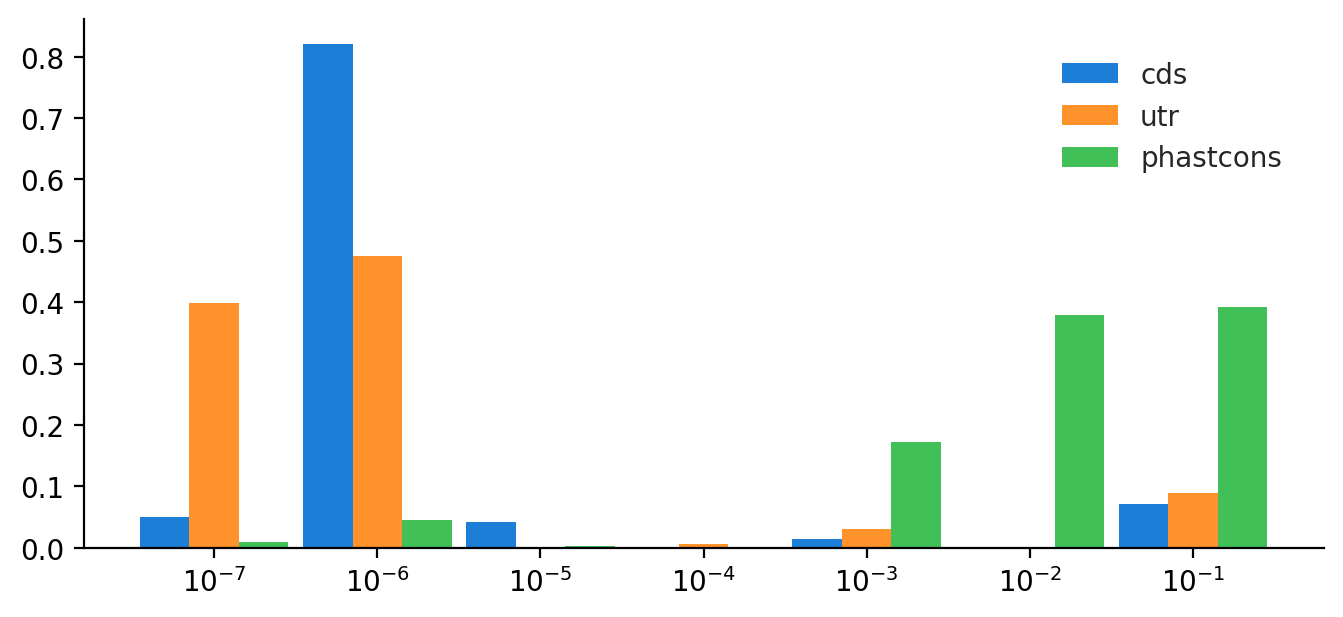

In [992]:
#fit = ff[1] # f[1]
fit = f[1]
xt = np.log10(fit.t)

fig, ax = plt.subplots()

w = 1/3-0.03
hw = w/2
ax.bar(xt-w-hw, fit.mle_W_norm[:, 0], align='edge', width=w, label='cds')
ax.bar(xt-hw, fit.mle_W_norm[:, 2], align='edge', width=w, label='utr')
ax.bar(xt+w-hw, fit.mle_W_norm[:, 1], align='edge', width=w, label='phastcons')

ax.set_xticks(np.log10(fit.t), [f"$10^{{{int(x)}}}$" for x in xt])
ax.legend()

## PhyloFit Branch Length Estimates

In [7]:
cols = ['chrom', 'start', 'end', 'branch_length', 'bl_nbases']
p = pd.read_csv('../data/phylo/phylofit_rates.bed', sep='\t', na_values='.', names=cols)

In [8]:
p.head()

,chrom,start,end,branch_length,bl_nbases
0,chr1,1059994,1095749,0.010402,72265
1,chr1,1283738,1308299,0.006782,52319
2,chr1,1564773,1623511,0.010483,178850
3,chr1,1626991,1655940,0.006026,63570
4,chr1,1752959,1789083,0.008125,86103


[]

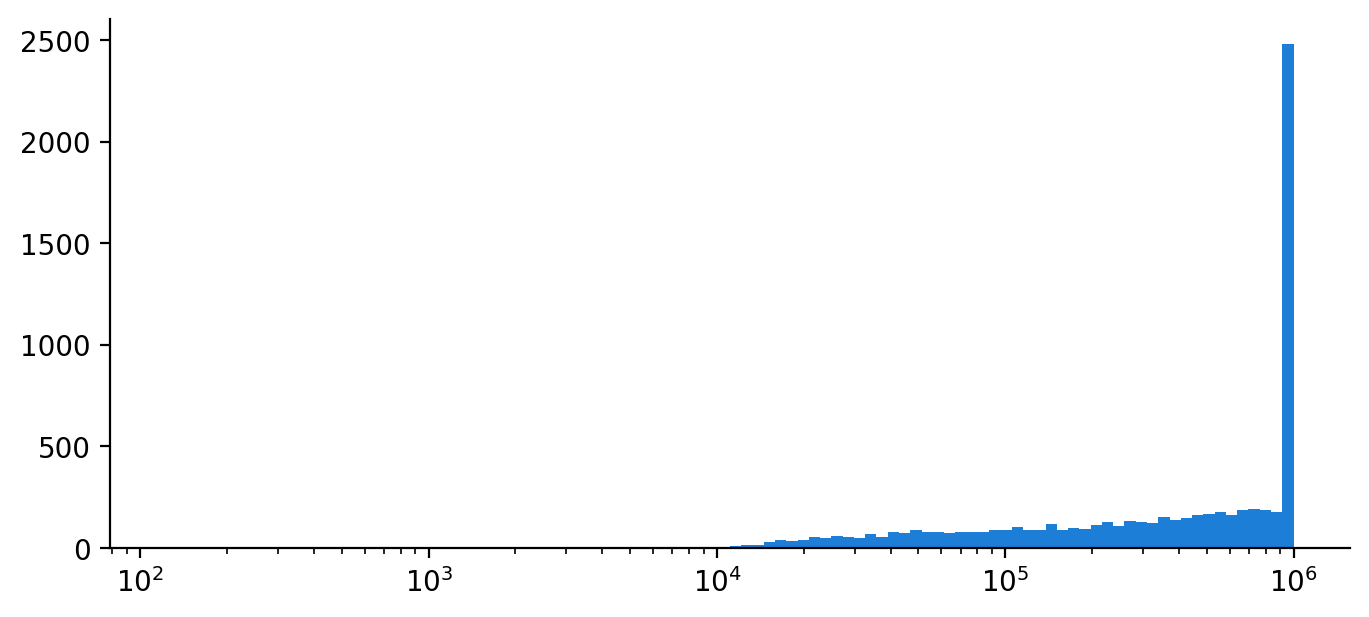

In [9]:
plt.hist(*logbins(p['bl_nbases'], 100))
plt.semilogx()

Esemble's data includes alignments only up to a megabase in length, hence the over-representation of this bin.

In [10]:
p['bl_nbases'].max()

1000000

### Merged Predicted Ratchet Rates and PhyloFit Branch Lengths

In [1103]:
# There are two ways to process this. 

# this way is wrong — much noisier estimates!
dpf2r = pd.read_csv('../data/phylo/phylofit_to_ratchet.bed', sep='\t',
                 na_values='.',
                 names=('chrom', 'start', 'end', 'R', 'r', 'r_nbases', 'branch_length'))

dr2pf = pd.read_csv('../data/phylo/ratchet_to_phylofit.bed', sep='\t',
                na_values='.',
                names=('chrom', 'start', 'end', 'branch_length', 'bl_nbases', 'r', 'r_nbases'))

# remove X!
dr2pf = dr2pf.loc[dr2pf['chrom'] != 'chrX']

dr2pf['width'] = dr2pf['end'] - dr2pf['start']
dr2pf.head()                

,chrom,start,end,branch_length,bl_nbases,r,r_nbases,width
0,chr1,1059994,1095749,0.010402,72265,1.749256e-08,6851.0,35755
1,chr1,1283738,1308299,0.006782,52319,4.189097e-08,6842.0,24561
2,chr1,1564773,1623511,0.010483,178850,3.405017e-08,4785.0,58738
3,chr1,1626991,1655940,0.006026,63570,4.291974e-08,7670.0,28949
4,chr1,1752959,1789083,0.008125,86103,5.100077e-08,4842.0,36124


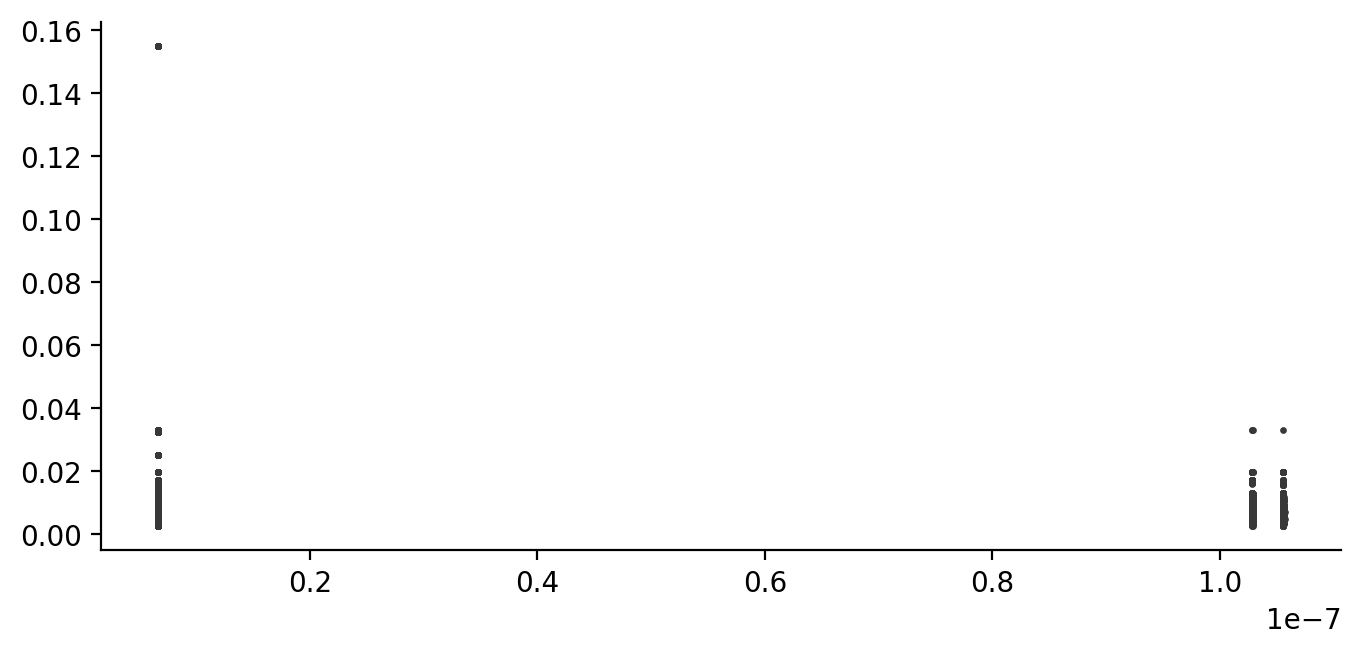

In [1104]:
plt.scatter(dpf2r['r'], dpf2r['branch_length'], c='0.22', s=2)

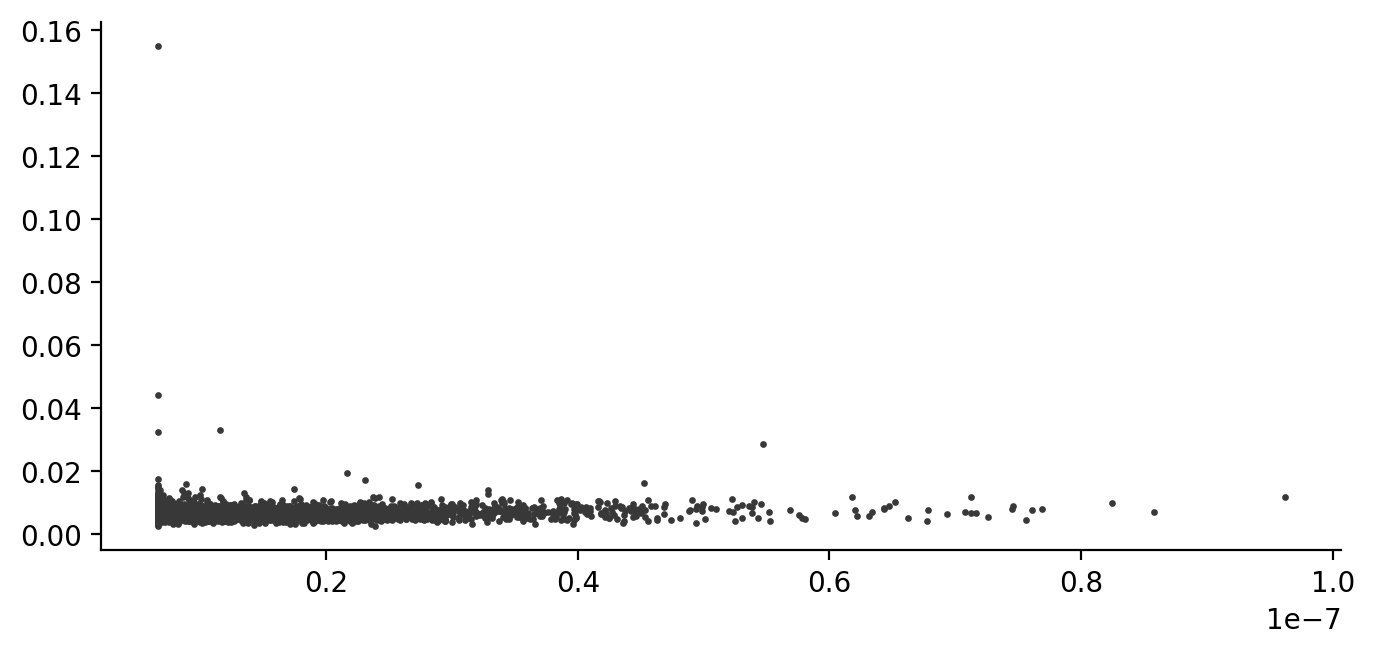

In [1042]:
plt.scatter(dr2pf['r'], dr2pf['branch_length'], c='0.22', s=2)

There look to be a few outliers.

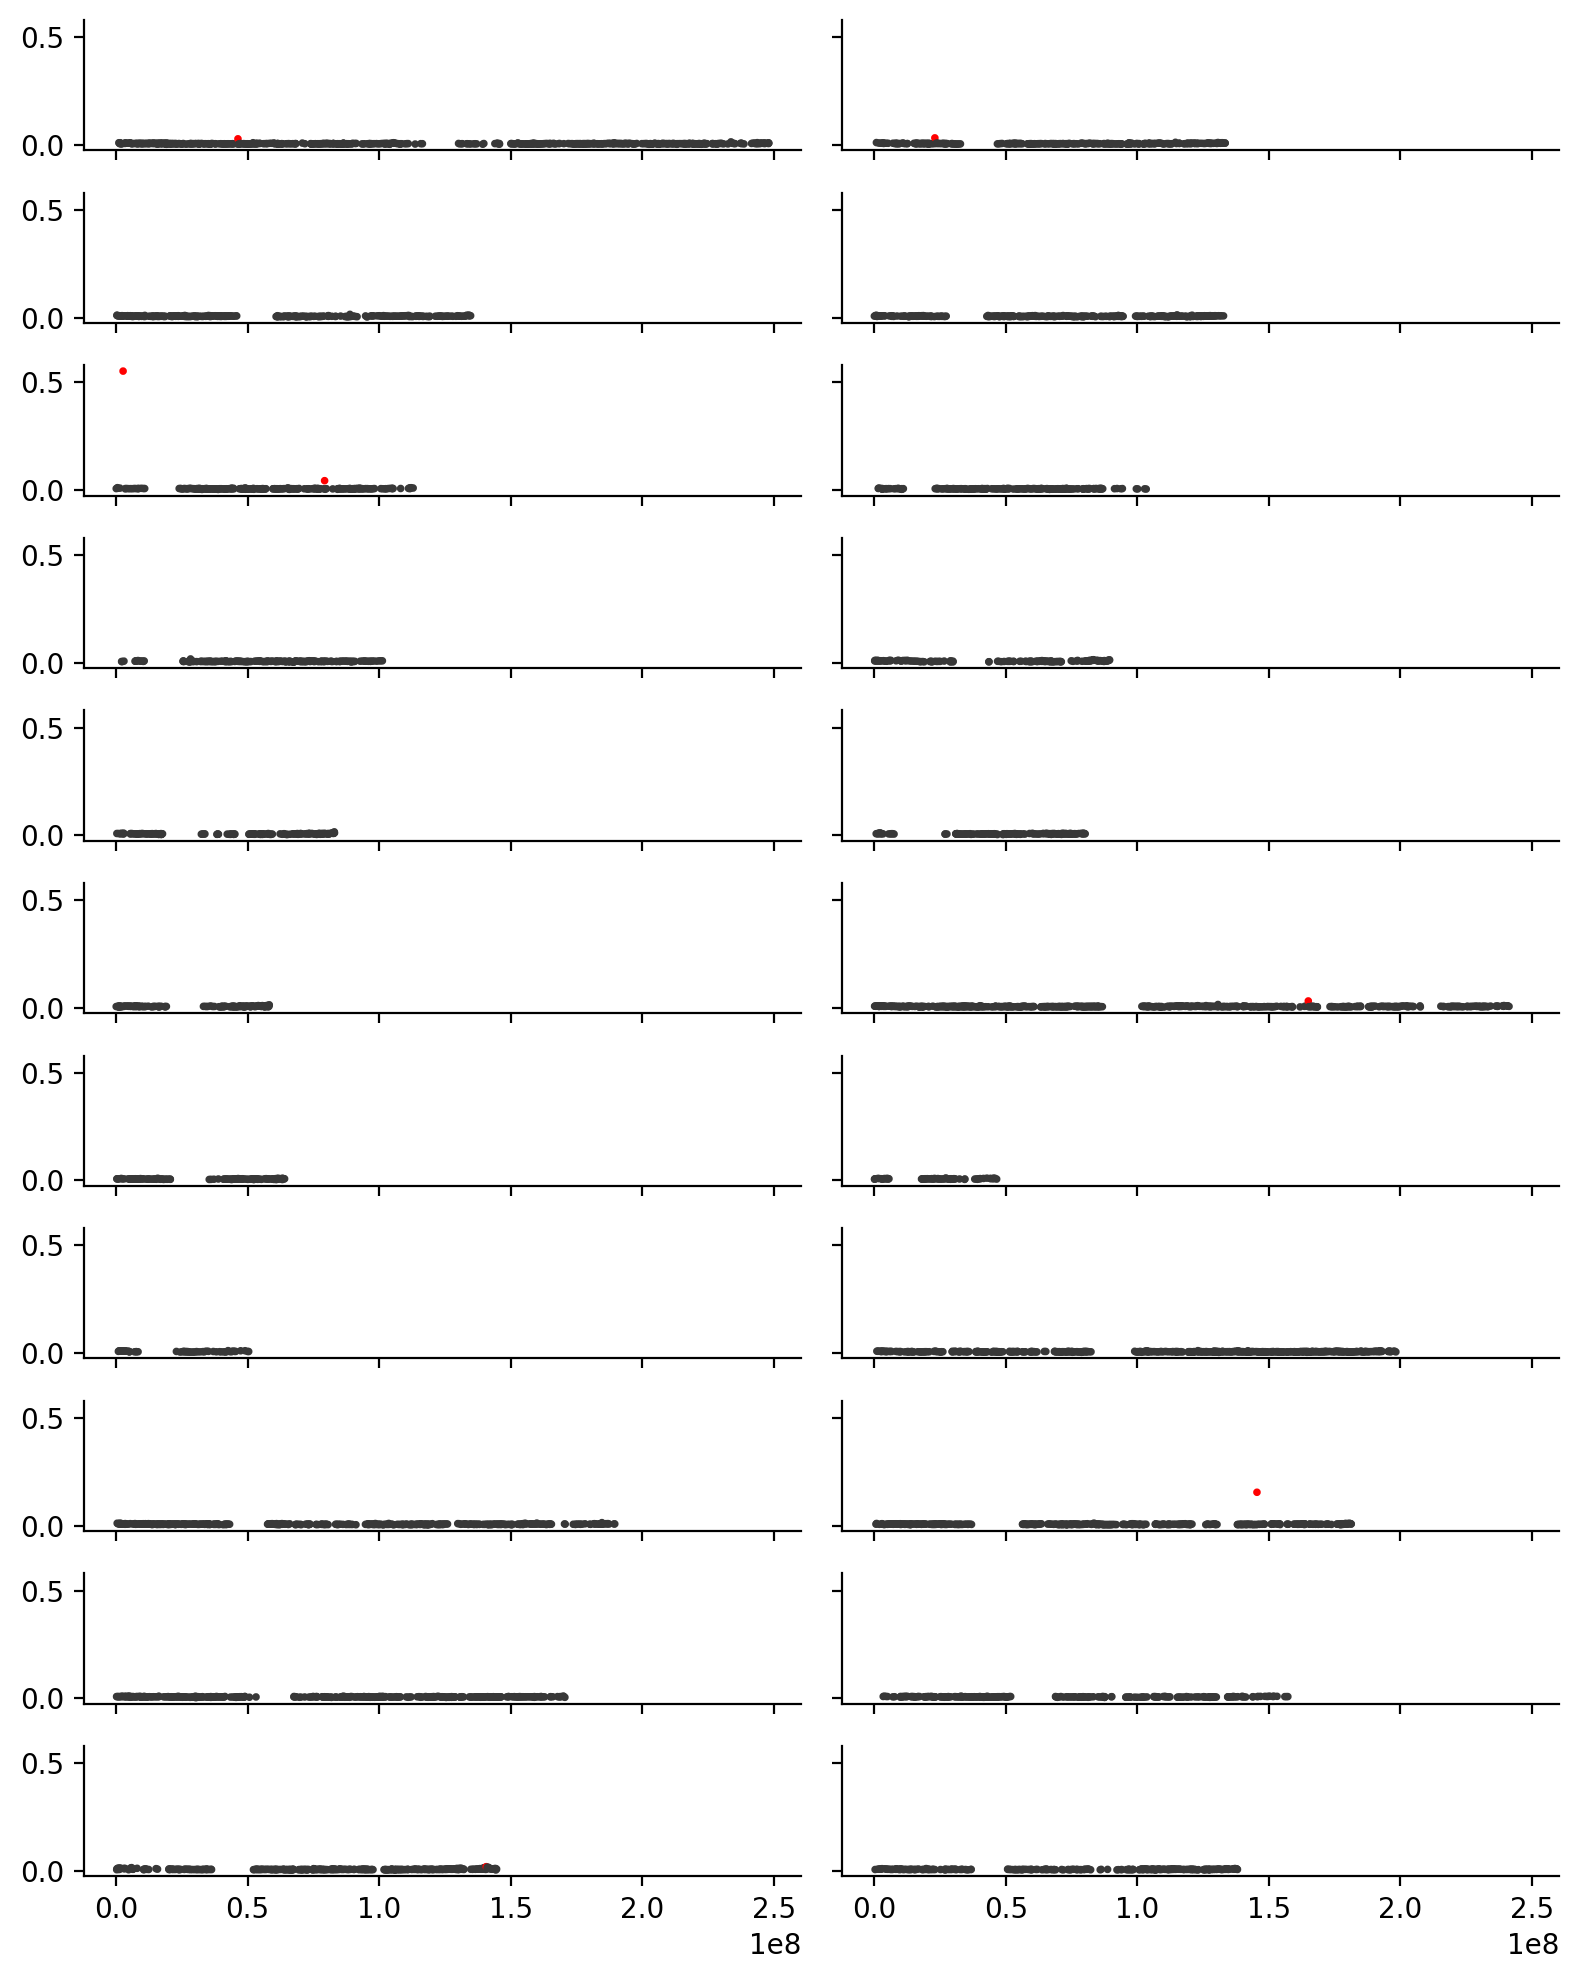

In [1043]:
r2pf_thresh = np.nanquantile(dr2pf['branch_length'], 0.999)

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True, sharey=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(dr2pf['chrom'].unique()):
    dx = dr2pf.loc[dr2pf['chrom'] == chrom]
    exclude = dx['branch_length'] > r2pf_thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['branch_length'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    
plt.tight_layout()

In [1044]:
dr2pfo = dr2pf.loc[dr2pf['branch_length'] < r2pf_thresh]

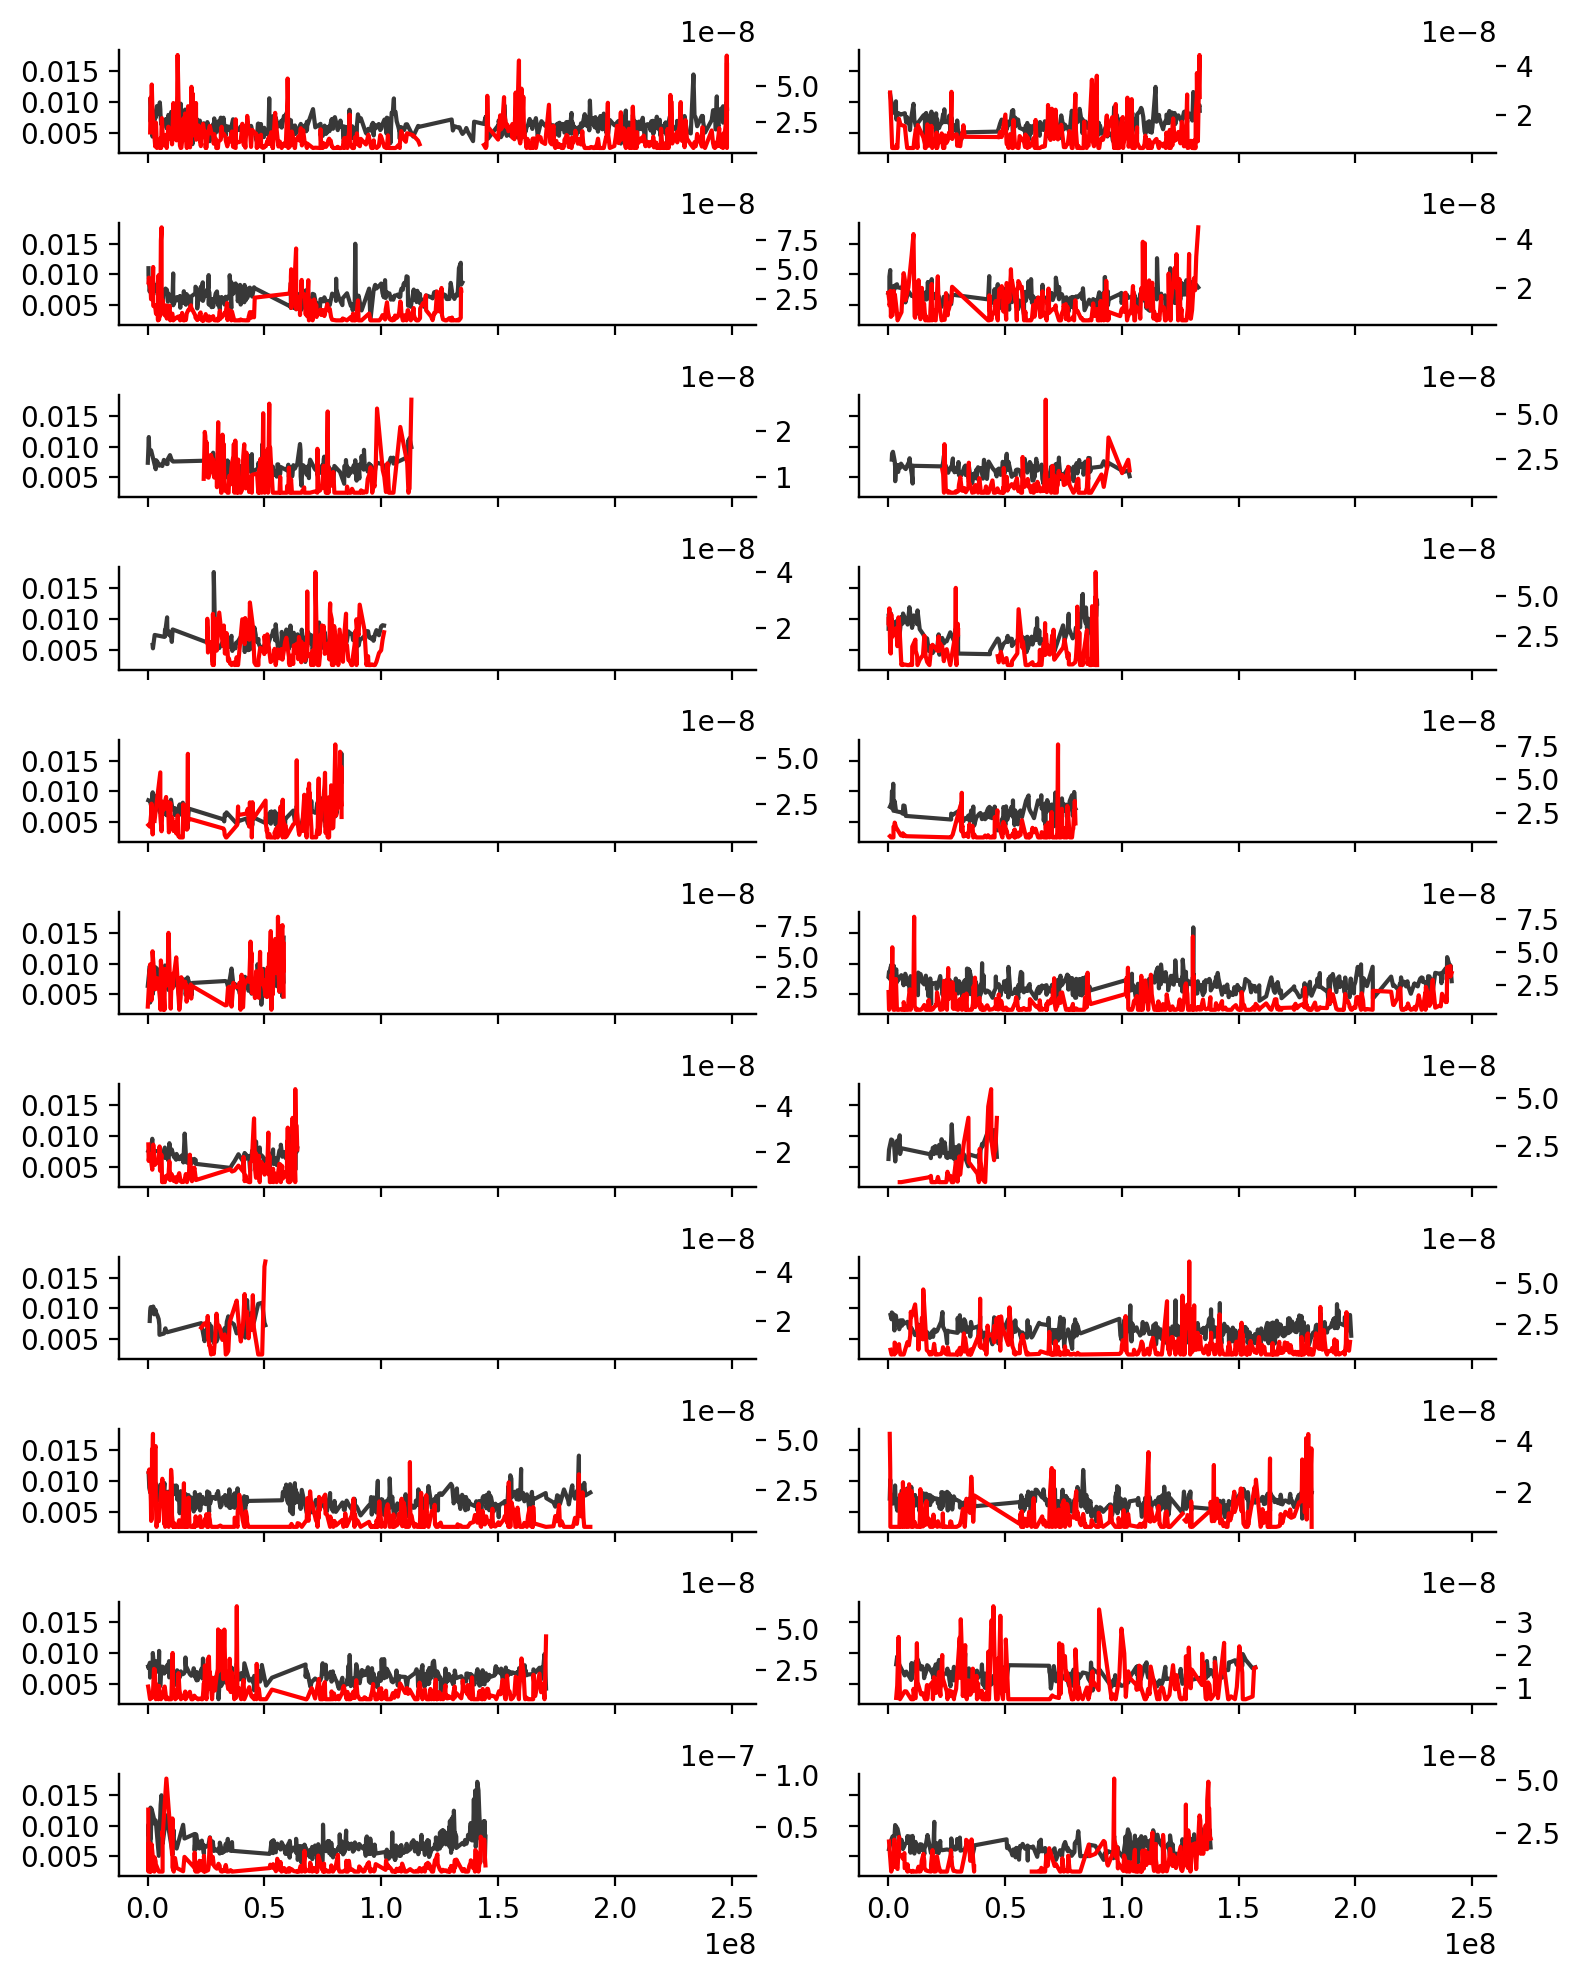

In [1053]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True, sharey=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(dr2pfo['chrom'].unique()):
    dx = dr2pfo.loc[dr2pf['chrom'] == chrom]
    exclude = dx['branch_length'] > r2pf_thresh
    fax = ax[rows.flat[i], cols.flat[i]]
    fax.plot(dx['start'], dx['branch_length'], c='0.22')
    ax2 = fax.twinx()
    ax2.plot(dx['start'], dx['r'], c='r')
plt.tight_layout()

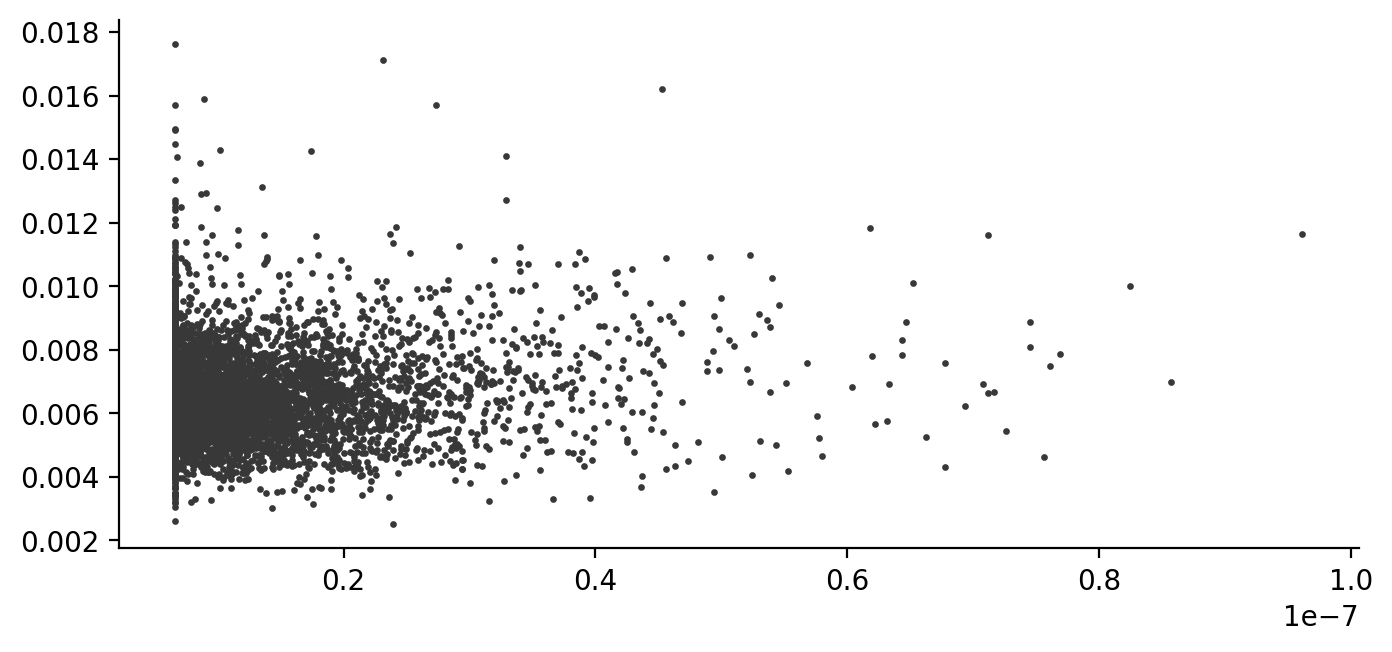

In [1054]:
plt.scatter(dr2pfo['r'], dr2pfo['branch_length'], c='0.22', s=2)

### Binned Ratchet Rates (Megabase)

In [829]:
cols = ('chrom', 'start', 'end', 'R', 'r', 'r_bases')
r1Mb = pd.read_csv('../data/phylo/ratchet_rates_binned_1000000.bed', names=cols,
                   na_values='.', sep='\t')

### Raw Ratchet Data

In [1016]:
cols = ['chrom', 'start', 'end', 'feature', 'R', 'r', 'seglen']

rd = pd.read_csv('../data/phylo/ratchet_data.bed', sep='\t', names=cols)
                     
rd.groupby('feature')['r'].mean()

feature
cds          1.055389e-07
phastcons    6.620515e-09
utr          1.028444e-07
Name: r, dtype: float64

### Urrichio et al Substitution Data

In [994]:
cols = [
    "chrom",
    "start",
    "end",
    "gene_id",
    "n_nonsyn",
    "n_syn",
    "fixed_nonsyn",
    "fixed_syn",
    "dnDs",
    "total_fixed",
    "len",
    "cai",
    "gc",
    "gc3",
    "syn_prop",
    "nonsyn_prop",
    "total_prop",
    "dNdS",
    "r",
    "r_nbases",
    "branch_length",
    "bl_nbases",
]

d = pd.read_csv('../data/phylo/urrichio_data_merged.bed', sep='\t', na_values='.', names=cols)
d['width'] = d['end'] - d['start']

In [995]:
d.head()

,chrom,start,end,gene_id,n_nonsyn,n_syn,fixed_nonsyn,fixed_syn,dnDs,total_fixed,...,gc3,syn_prop,nonsyn_prop,total_prop,dNdS,r,r_nbases,branch_length,bl_nbases,width
0,chr1,923923,944575,ENSG00000187634,28,21,8,4,2.000000,12,...,0.832938,0.001580,0.003160,0.004739,2.000000,2.502833e-08,4658,NaN,NaN,20652
1,chr1,944203,959309,ENSG00000188976,31,32,4,8,0.500000,12,...,0.794393,0.003560,0.001780,0.005340,0.500000,4.107783e-08,2950,NaN,NaN,15106
2,chr1,960584,965719,ENSG00000187961,11,28,0,8,0.000000,8,...,0.838006,0.004154,0.000000,0.004154,0.000000,4.222435e-08,2776,NaN,NaN,5135
3,chr1,966482,975865,ENSG00000187583,47,19,0,3,0.000000,3,...,0.801964,0.001637,0.000000,0.001637,0.000000,3.766140e-08,3800,NaN,NaN,9383
4,chr1,975198,982117,ENSG00000187642,31,22,11,3,3.666667,14,...,0.681013,0.001266,0.004641,0.005907,3.666667,4.105993e-08,4203,NaN,NaN,6919


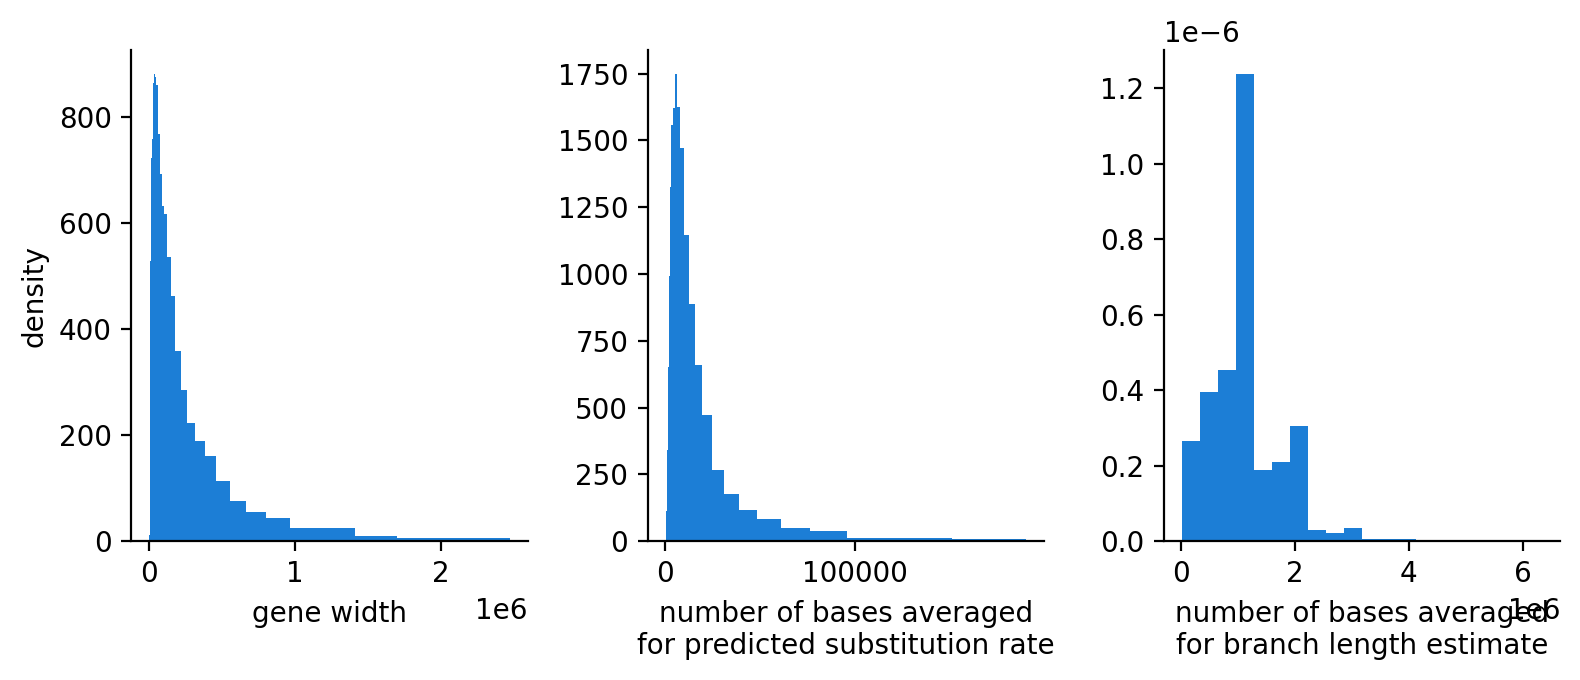

In [996]:
# width of genes, number of bases averaged for ratchet estimate, 
# number of bases averaged for 

fig, ax = plt.subplots(ncols=3)


ax[0].hist(*logbins(d['width'], 50, density=True))
ax[1].hist(*logbins(d['r_nbases'], 30, density=True))
_ = ax[2].hist(d['bl_nbases'], 20, density=True)
ax[0].set_ylabel('density')
ax[0].set_xlabel('gene width')
ax[1].set_xlabel('number of bases averaged\nfor predicted substitution rate')
ax[2].set_xlabel('number of bases averaged\nfor branch length estimate')
plt.tight_layout()

In [997]:
d['bl_nbases'].max()

6336248.0

Text(0.5, 0, 'predicted substitution rate')

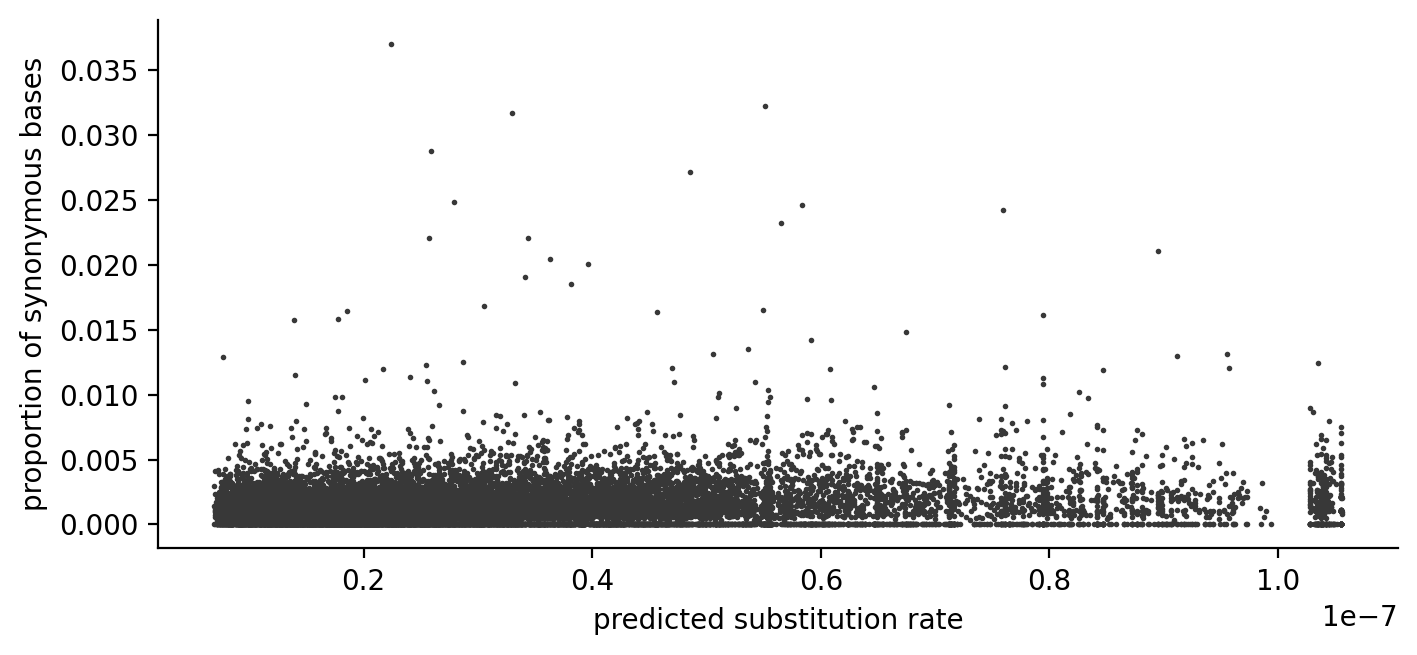

In [998]:
fig, ax = plt.subplots()
ax.scatter(d['r'], d['syn_prop'], c='0.22', s=1, alpha=1)
ax.set_ylabel('proportion of synonymous bases')
ax.set_xlabel('predicted substitution rate')

Text(0.5, 0, 'predicted substitution rate')

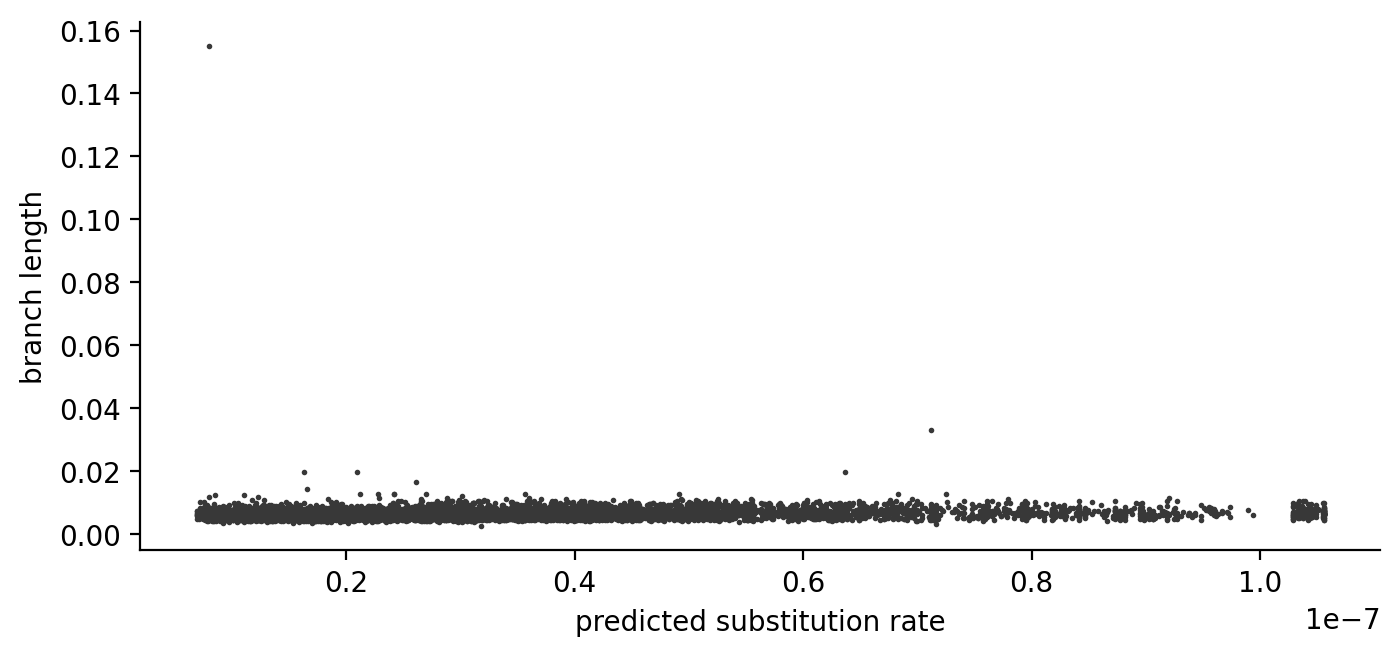

In [999]:
fig, ax = plt.subplots()
ax.scatter(d['r'], d['branch_length'], c='0.22', s=1, alpha=1)
ax.set_ylabel('branch length')
ax.set_xlabel('predicted substitution rate')

Note the strange clump of high predicted substitution rates in both of these figures — what's going on?

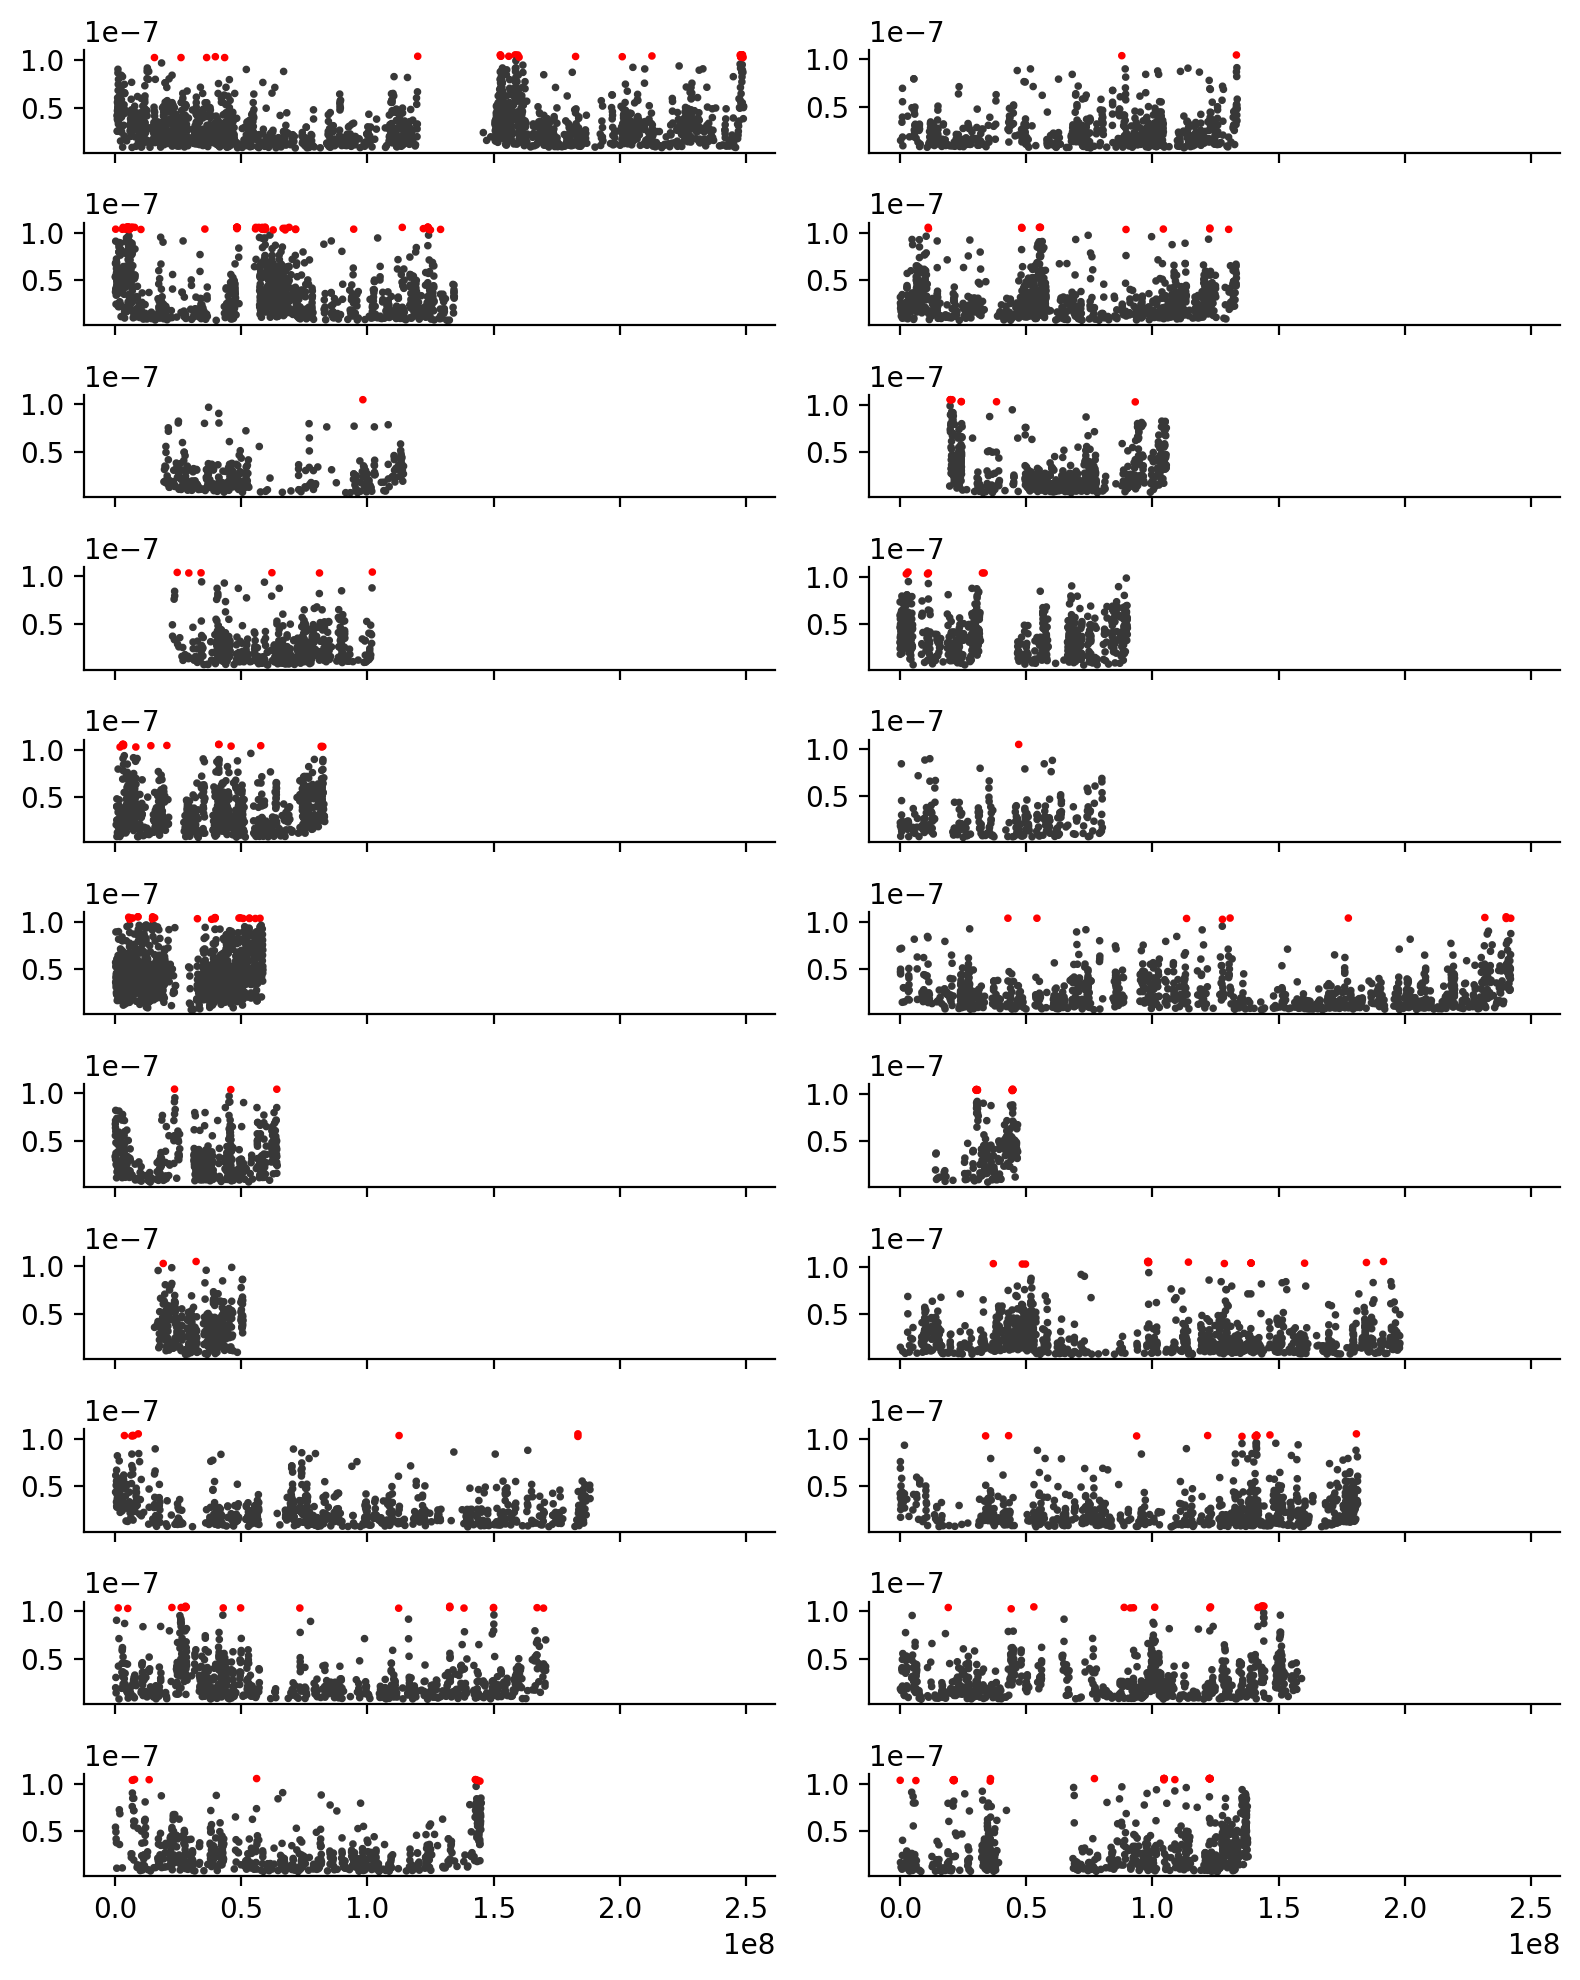

In [1005]:
r_thresh = 1e-7

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    exclude = dx['r'] > r_thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['r'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    
plt.tight_layout()

This looks to be some pathology — we will remove these.

Now let's look at branch length (from PhyloFit) in the Urrichio et al data along the genome. Immediately we see some very strong outliers that we remove.

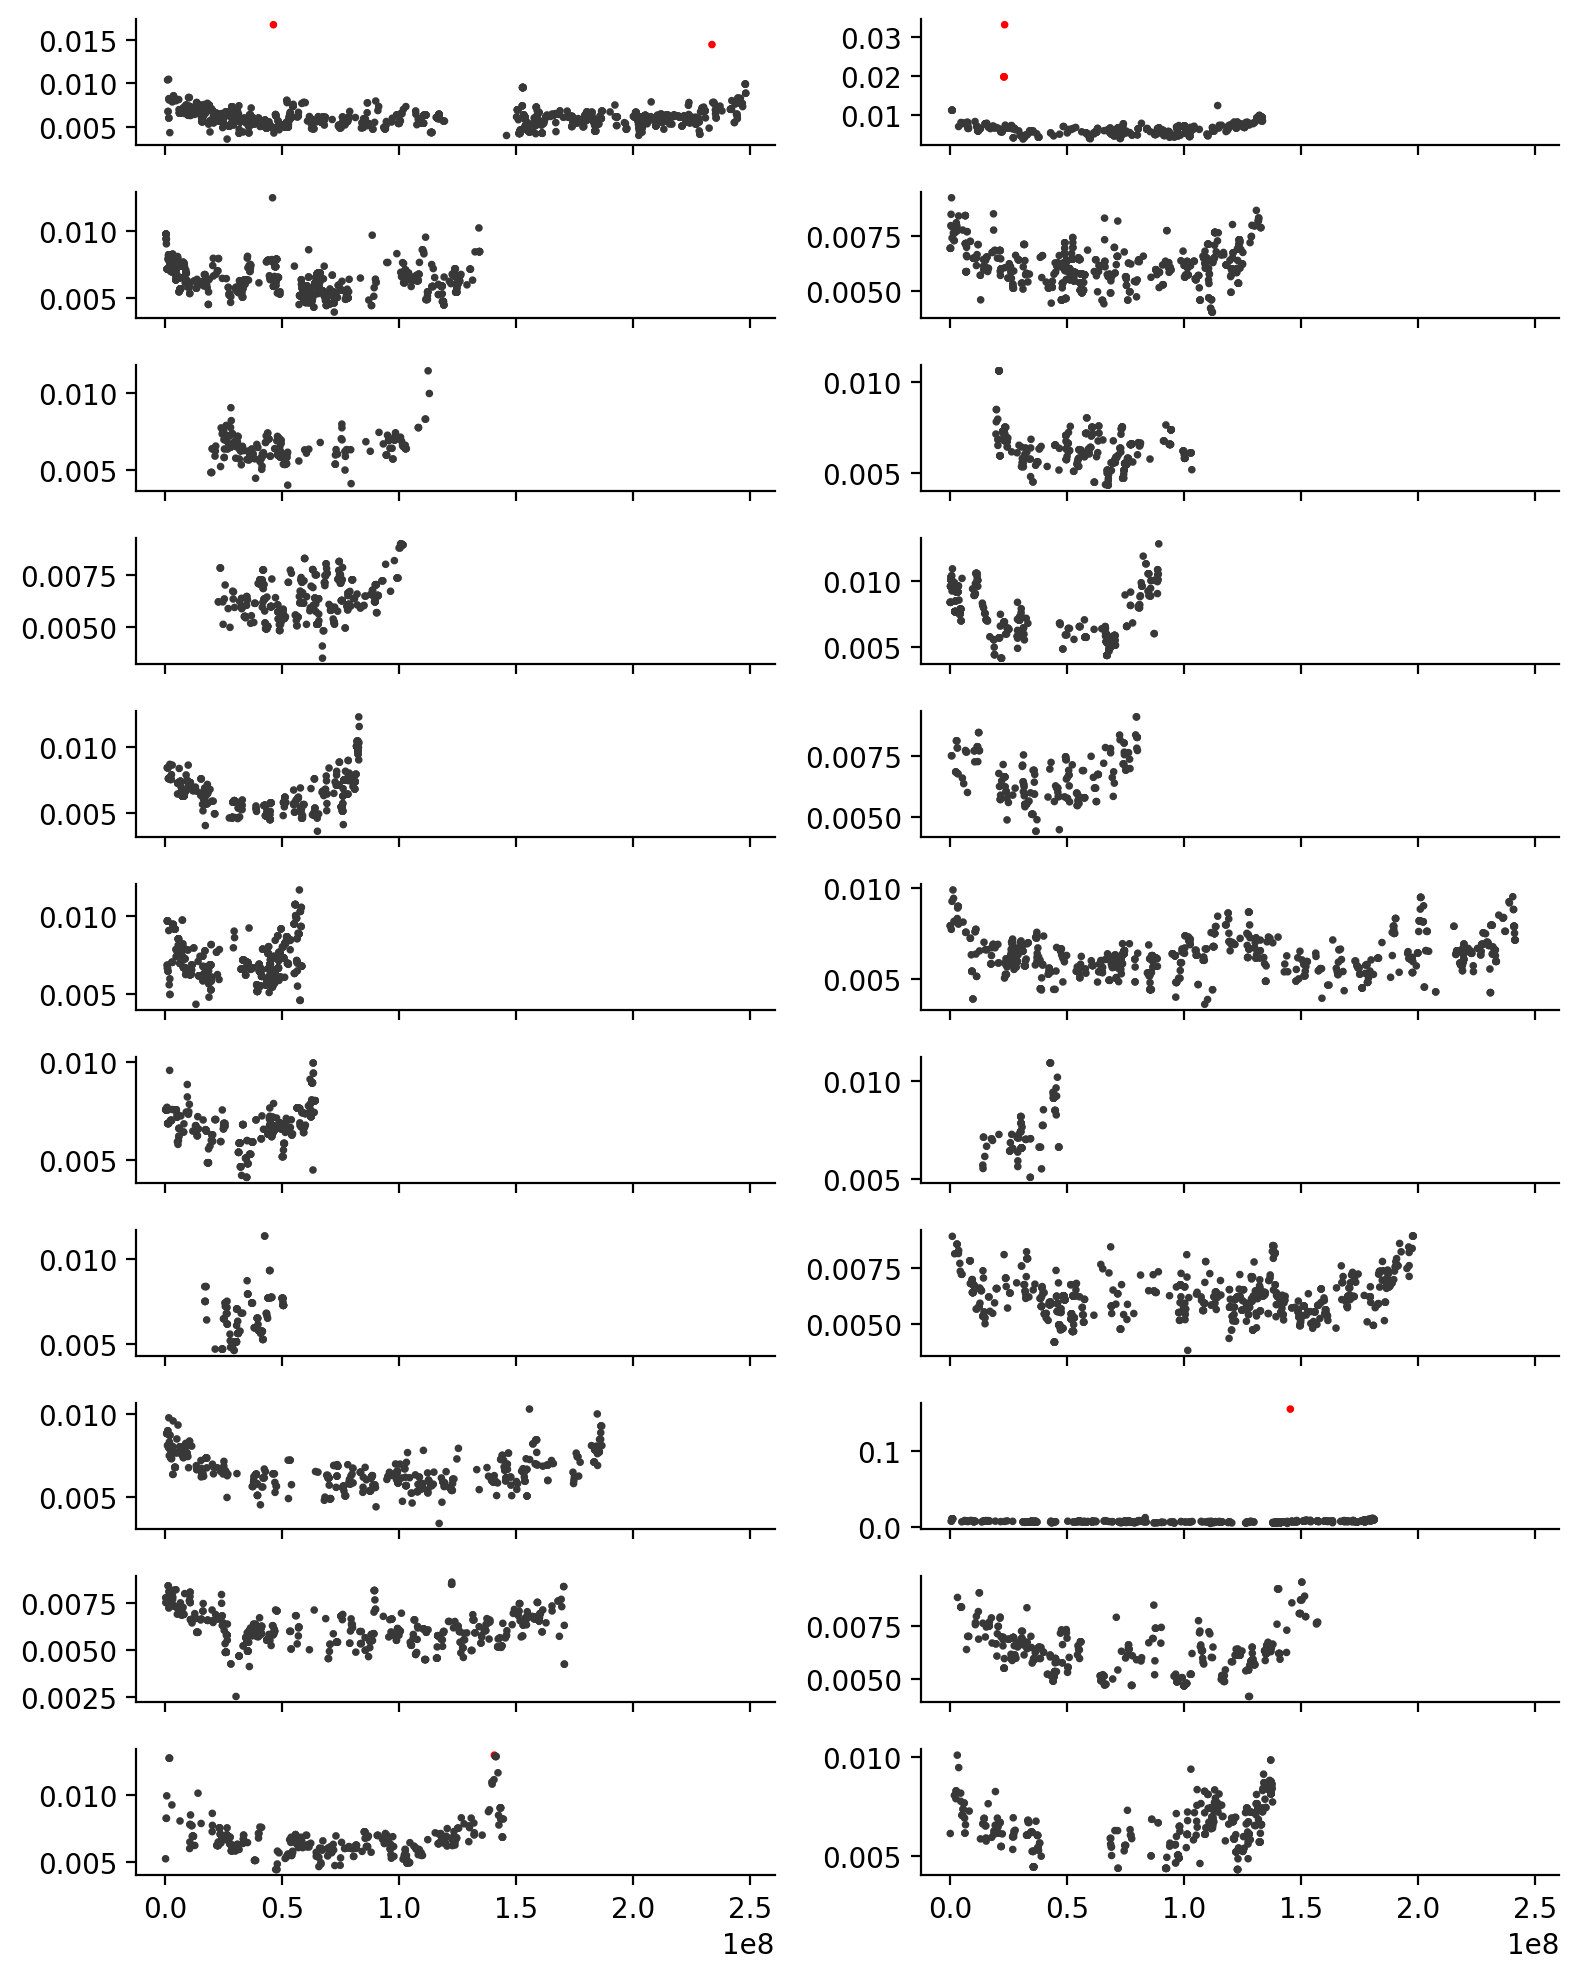

In [1008]:
thresh = np.nanquantile(d['branch_length'], 0.999)

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    exclude = dx['branch_length'] > thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['branch_length'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    
plt.tight_layout()

In [1009]:
# remove outliers
do = d.loc[(d['branch_length'] < thresh) & (d['r'] < r_thresh)]

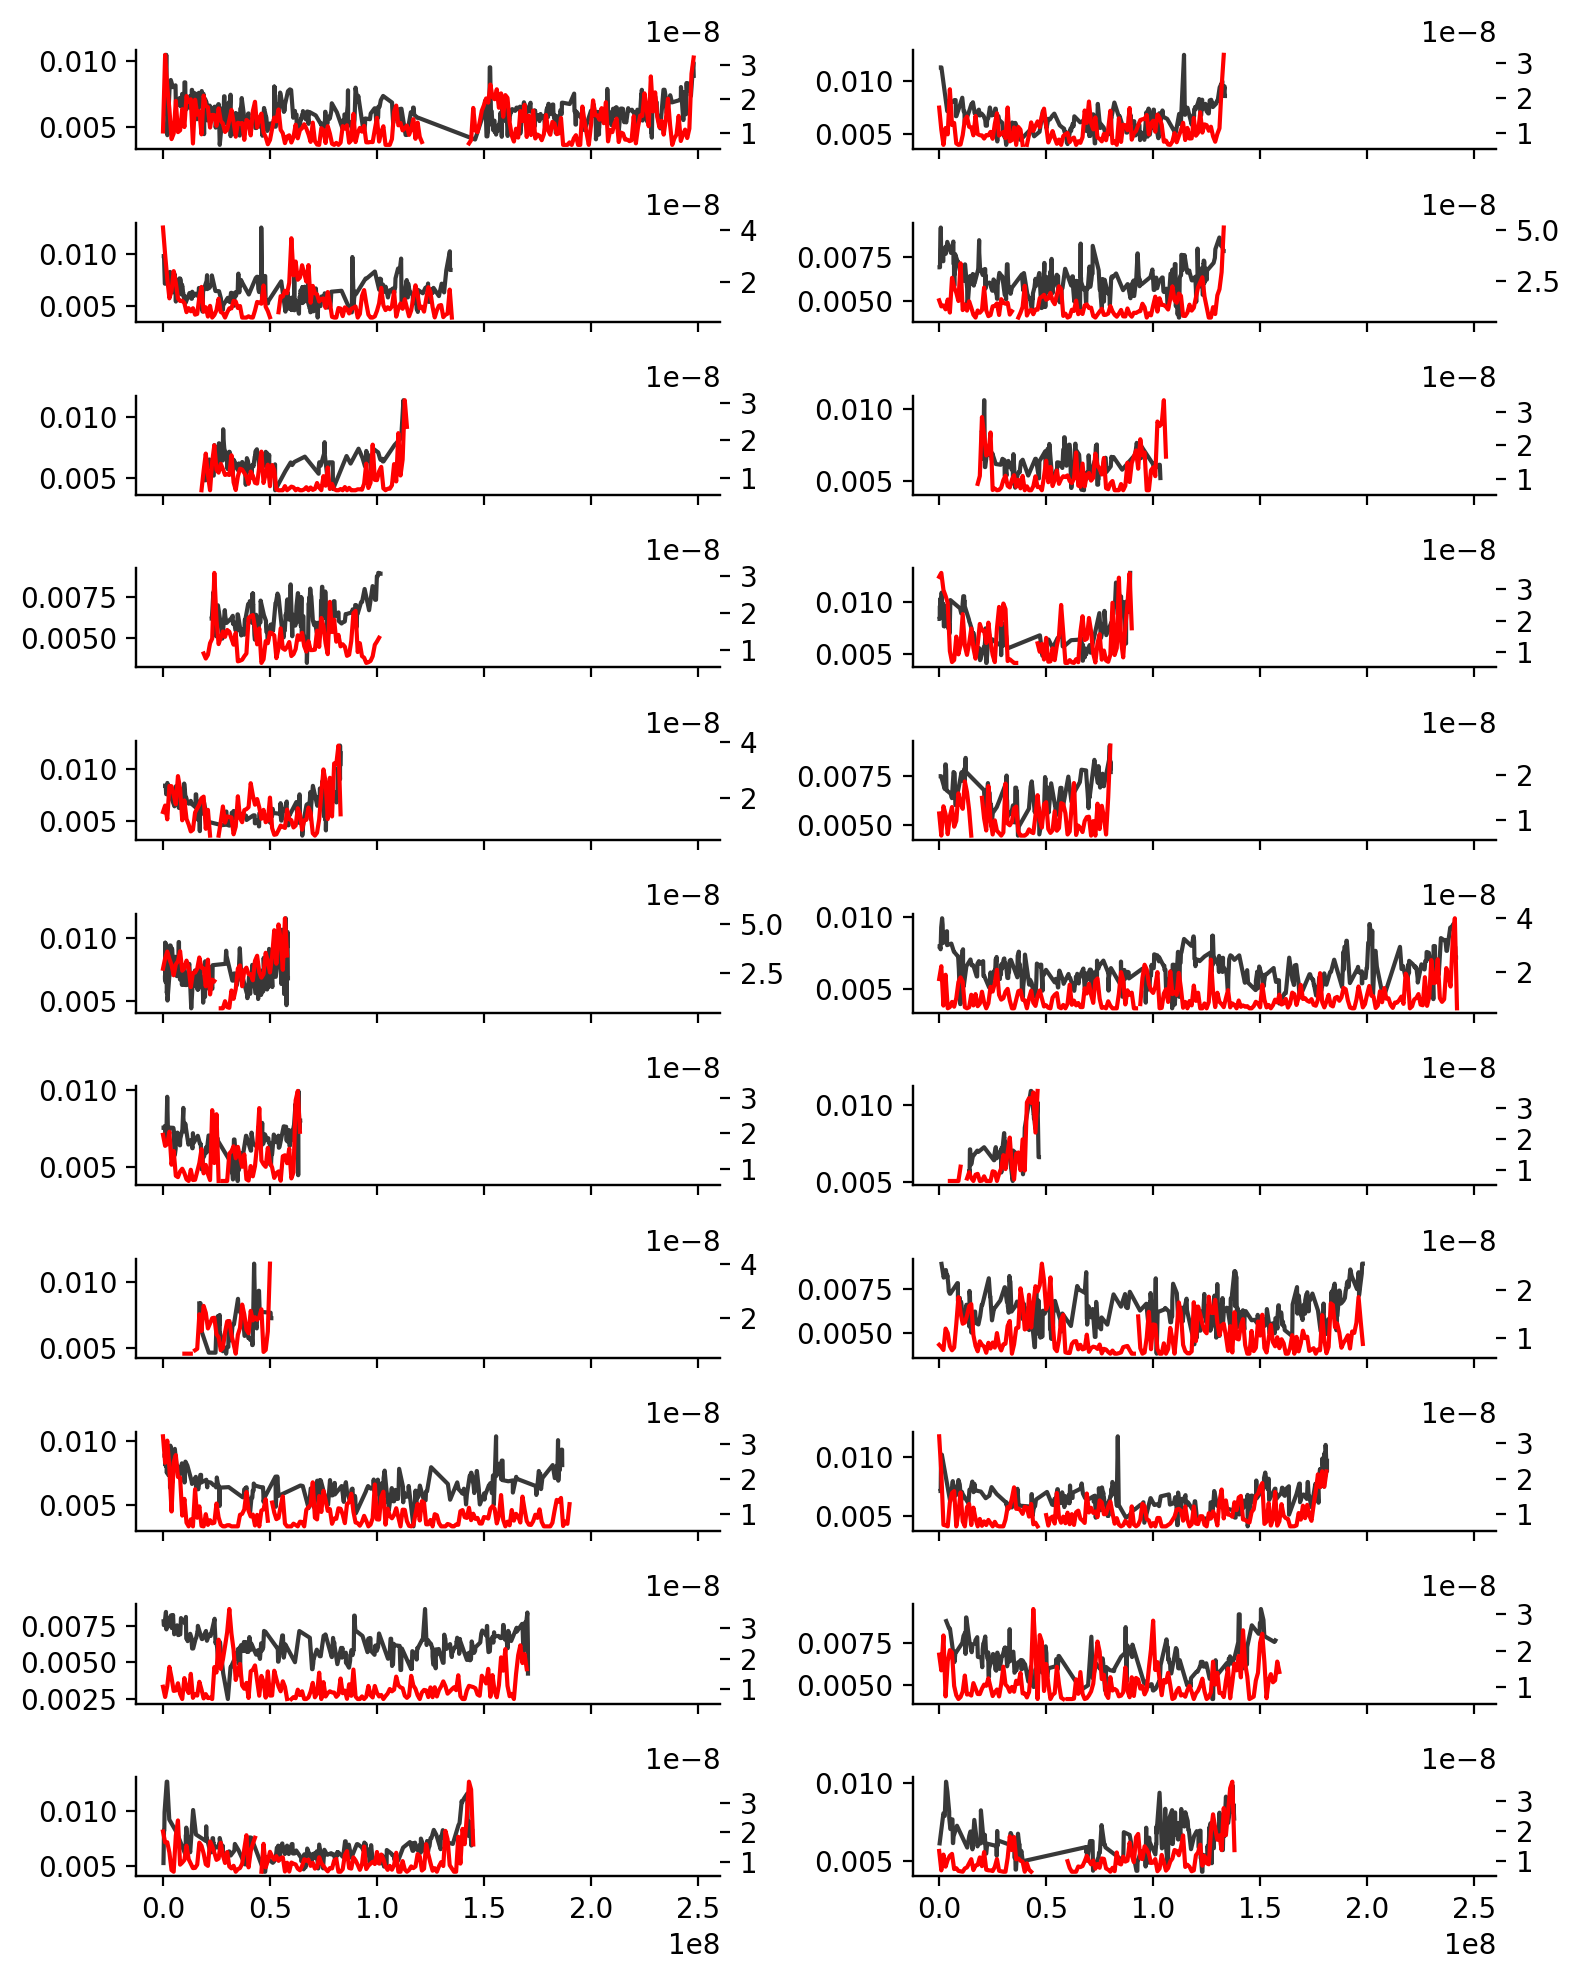

In [1010]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(do['chrom'].unique()):
    dx = do.loc[do['chrom'] == chrom]
    exclude = dx['branch_length'] > thresh
    fax = ax[rows.flat[i], cols.flat[i]]
    fax.plot(dx['start'], dx['branch_length'], c='0.22')
    ax2 = fax.twinx()
    rx = r1Mb.loc[r1Mb['chrom'] == chrom]
    ax2.plot(rx['start'], rx['r'], c='r')
plt.tight_layout()

There's some rough correpondance here — we will explore this more later.

### Cross Validation of Bin Width

In [1088]:
x, branch_length = dr2pfo['r'].values, dr2pfo['branch_length'].values
keep = np.isfinite(x) & np.isfinite(branch_length)
x, branch_length = x[keep], branch_length[keep]

In [1089]:
branch_length.shape, x.shape

((6147,), (6147,))

In [1090]:
#x, syn_prop, nonsyn_prop, branch_length = (do['r'].values, do['syn_prop'].values,
#                                           do['nonsyn_prop'].values, do['branch_length'].values)

# nbins = 50
# dns = binned_summaries(x, nonsyn_prop, nbins)
# ds = binned_summaries(x, syn_prop, nbins)
# dbl = binned_summaries(x, branch_length, nbins)

In [1091]:
import warnings
from sklearn.model_selection import KFold, LeaveOneOut
from collections import defaultdict

warnings.filterwarnings(action='once')


bin_range = (x.min(), 1.001*x.max())


kf = KFold(n_splits=100)
loo = LeaveOneOut()

mses = defaultdict(list)

cv_mses = []
nbs = []

def safe_mean(x):
    if not len(x) or np.all(~np.isfinite(x)):
        return np.nan
    return np.nanmean(x)

for nb in np.arange(5, 200, 2).astype(int):
    for train, test in kf.split(x):
        bins = cutbins(x[train], nb, xrange=bin_range)
        bin_means = binned_statistic(x[train], branch_length[train], statistic=safe_mean, bins=bins)
        bin_ns = binned_statistic(x[train], branch_length[train], statistic=lambda x: np.sum(np.isfinite(x)), bins=bins)
        idx = np.digitize(x[test], bins)
        se = (bin_means.statistic[idx-1] - branch_length[test])**2
        weights = bin_ns.statistic[idx-1]
        keep = np.isfinite(se)
        mse = np.average(se[keep], weights=weights[keep])
        mses[nb].append(mse)
        cv_mses.append(mse)
        nbs.append(nb)
        

Text(0.5, 0, 'number of bins')

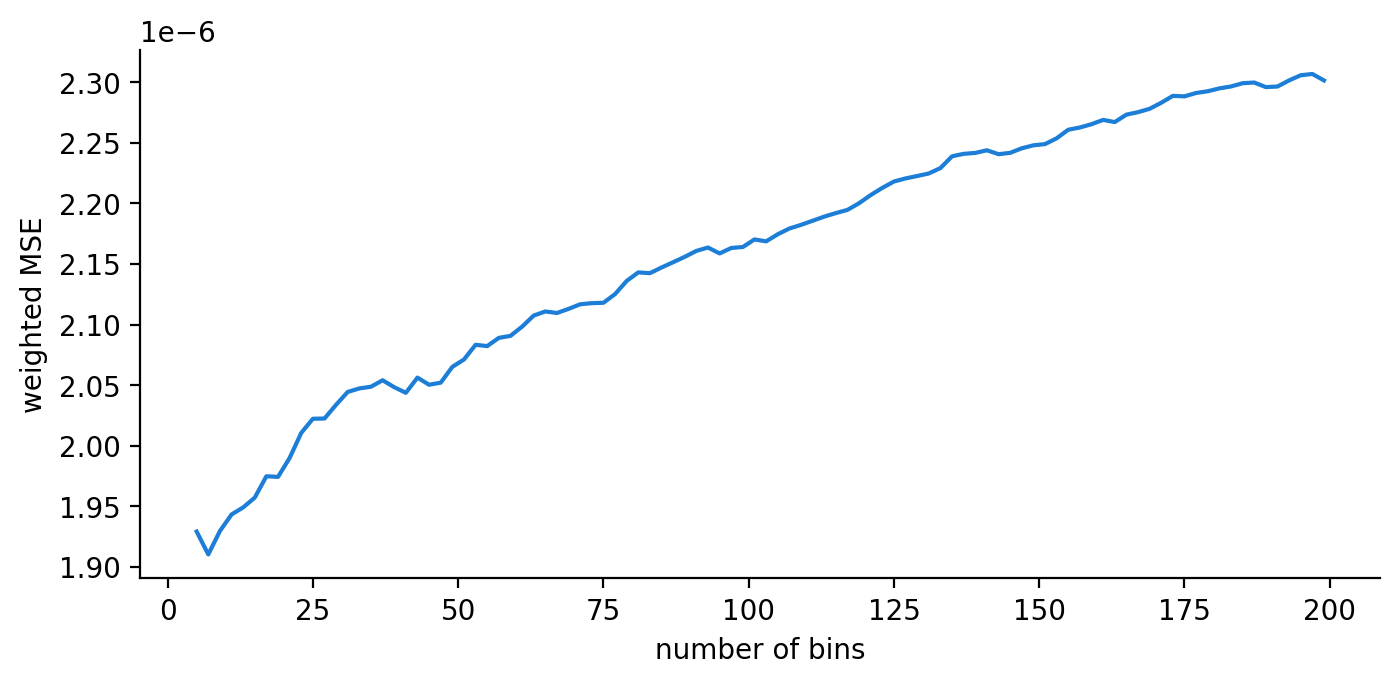

In [1094]:
msedat = {nb: np.mean(v) for nb, v in mses.items()}

plt.plot(msedat.keys(), msedat.values())
plt.ylabel("weighted MSE")
plt.xlabel("number of bins")

In [1095]:
best_nbin = list(msedat.keys())[np.argmin(list(msedat.values()))]
best_nbin

7

In [1097]:
def JC69(dist):
    # distance
    return 0.75 - 0.75*np.exp(-4/3 * dist)

def sub_model(lambda_d, beta, T, a, use_JC69=False):
    dist = a*T + T*beta*lambda_d
    if use_JC69`


def fit_JC69(predicted, subrate, gen_time=30):
    lambda_d, y = predicted/gen_time, subrate
    keep = np.isfinite(lambda_d) & np.isfinite(y)
    lambda_d, y = lambda_d[keep], y[keep]
    return lambda_d, y, curve_fit(JC69_parametric, lambda_d, y, p0=(0.02, 6e6, 0))

xx, yy, fit = fit_JC69(x, branch_length)

In [1098]:
fit

(array([7.59803031e-03, 4.31458274e+07, 1.49843883e-10]),
 array([[-2.49358940e+06,  1.41441510e+16, -4.91773386e-02],
        [ 1.41441510e+16, -8.02285284e+25,  2.78943961e+08],
        [-4.91773386e-02,  2.78943961e+08, -9.69851186e-10]]))

In [1107]:
dr2pfo_bins = binned_summaries(dr2pfo['r'], dr2pfo['branch_length'], nbins=50)

Text(0.5, 0, 'predicted substitution rate')

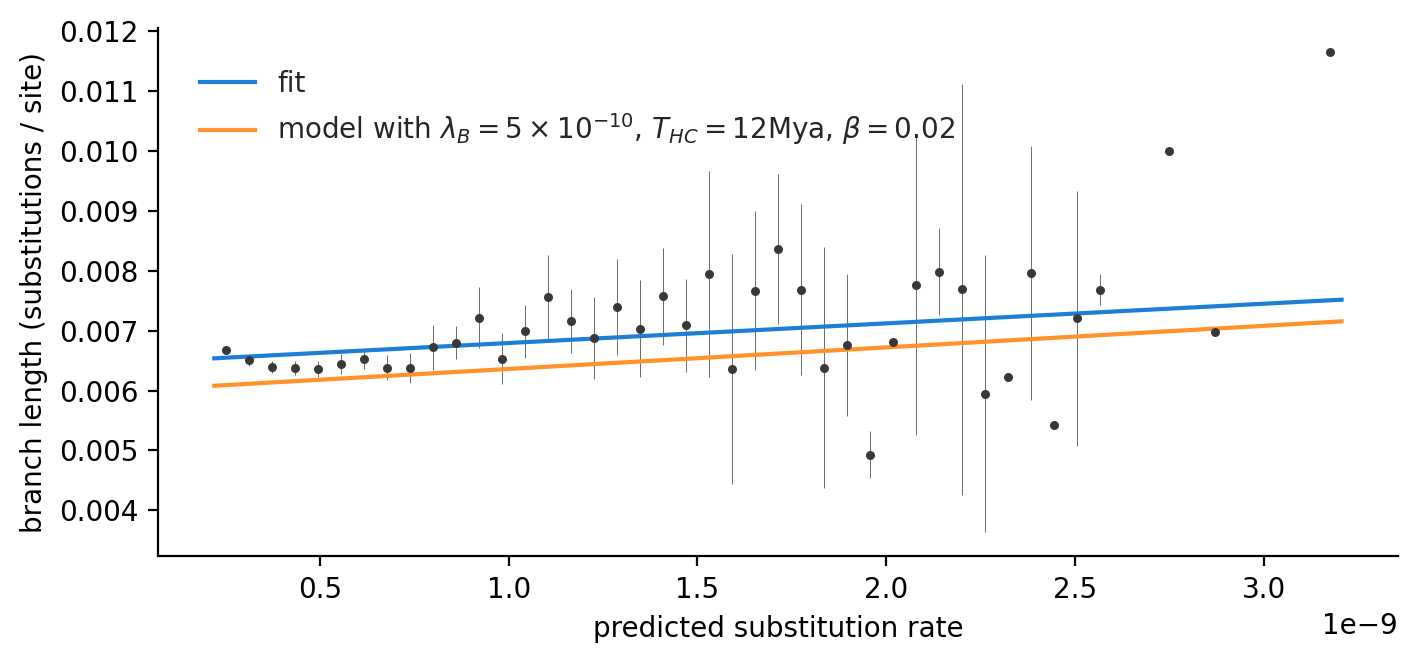

In [1108]:
fig, ax = plt.subplots()
ax.scatter(dr2pfo_bins['midpoint'].values/gen, dr2pfo_bins['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
ax.errorbar(dr2pfo_bins['midpoint']/gen, dr2pfo_bins['mean'], 2*dr2pfo_bins['sd']/np.sqrt(dr2pfo_bins['n']), fmt='none', c=error_col, elinewidth=0.3)

rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit[0]), label='fit')
#ax.plot(rate_grid, JC69_parametric(rate_grid, *bin_fit[0]), label='bin fit')

#ax.set_ylim(0.003, 0.012)


lit_lambda_b, lit_T, lit_beta = 5e-10, 12e6, 0.03
ax.plot(rate_grid, lit_lambda_b*lit_T + lit_T*lit_beta*rate_grid, 
        label='model with $\\lambda_B = 5\\times 10^{-10}$, $T_{HC} = 12$Mya, $\\beta = 0.02$')
ax.legend()
ax.set_ylabel("branch length (substitutions / site)")
ax.set_xlabel("predicted substitution rate")

In [1082]:
nbins = best_nbin
plt.scatter(*bin2pairs(binned_statistic(x, branch_length, np.nanmean, bins=cutbins(x, nbins))))
plt.scatter(*bin2pairs(binned_statistic(x, syn_prop, np.nanmean, bins=cutbins(x, nbins))))
plt.scatter(*bin2pairs(binned_statistic(x, nonsyn_prop, np.nanmean, bins=cutbins(x, nbins))))

AttributeError: The number of `values` elements must match the length of each `sample` dimension.

In [1017]:
nbins = best_nbin

dns = binned_summaries(x, nonsyn_prop, nbins)
ds = binned_summaries(x, syn_prop, nbins)
dbl = binned_summaries(x, branch_length, nbins)

In [1018]:
min_n = 30
dnsx = dns.loc[dns['n'] > min_n]
dsx = ds.loc[ds['n'] > min_n]
dblx = dbl.loc[dbl['n'] > min_n]


Text(0, 0.5, 'proportion substitutions')

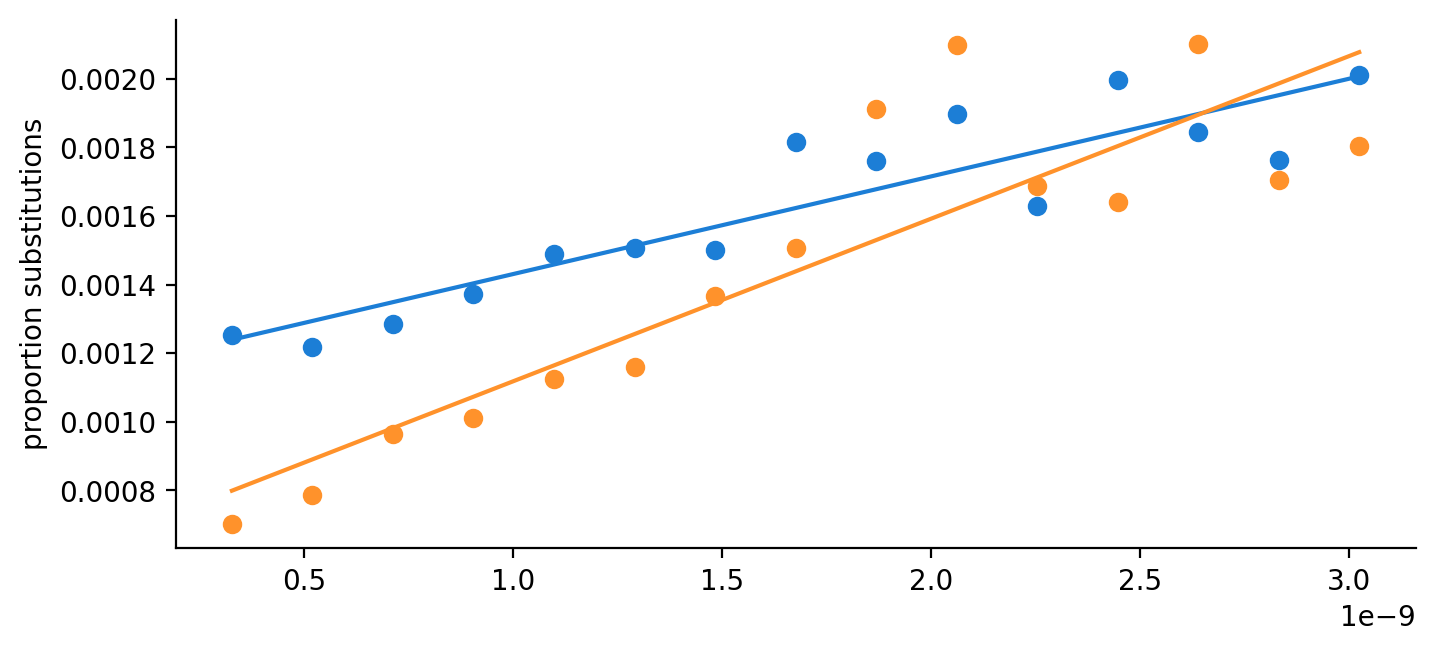

In [1019]:
syn_lfit = stats.linregress(dsx['midpoint']/gen, dsx['mean'])
nonsyn_lfit = stats.linregress(dnsx['midpoint']/gen, dnsx['mean'])

fig, ax = plt.subplots()
ax.scatter(dsx['midpoint']/gen, dsx['mean'], label='syn')
rate_grid = np.linspace(dsx['midpoint'].min(), dsx['midpoint'].max(), 100)/gen
ax.plot(rate_grid, syn_lfit.intercept + syn_lfit.slope*rate_grid)

ax.scatter(dnsx['midpoint']/gen, dnsx['mean'], label='non-syn')
ax.plot(rate_grid, nonsyn_lfit.intercept + nonsyn_lfit.slope*rate_grid)
ax.set_ylabel('proportion substitutions')

ValueError: operands could not be broadcast together with shapes (6147,) (6278,) 

In [1058]:
binned_r, binned_bl = dblx['midpoint'].values, dblx['mean'].values
r, bl = do['r'].values, do['branch_length'].values
r1, bl1 = dr2pfo['r'].values, dr2pfo['branch_length'].values

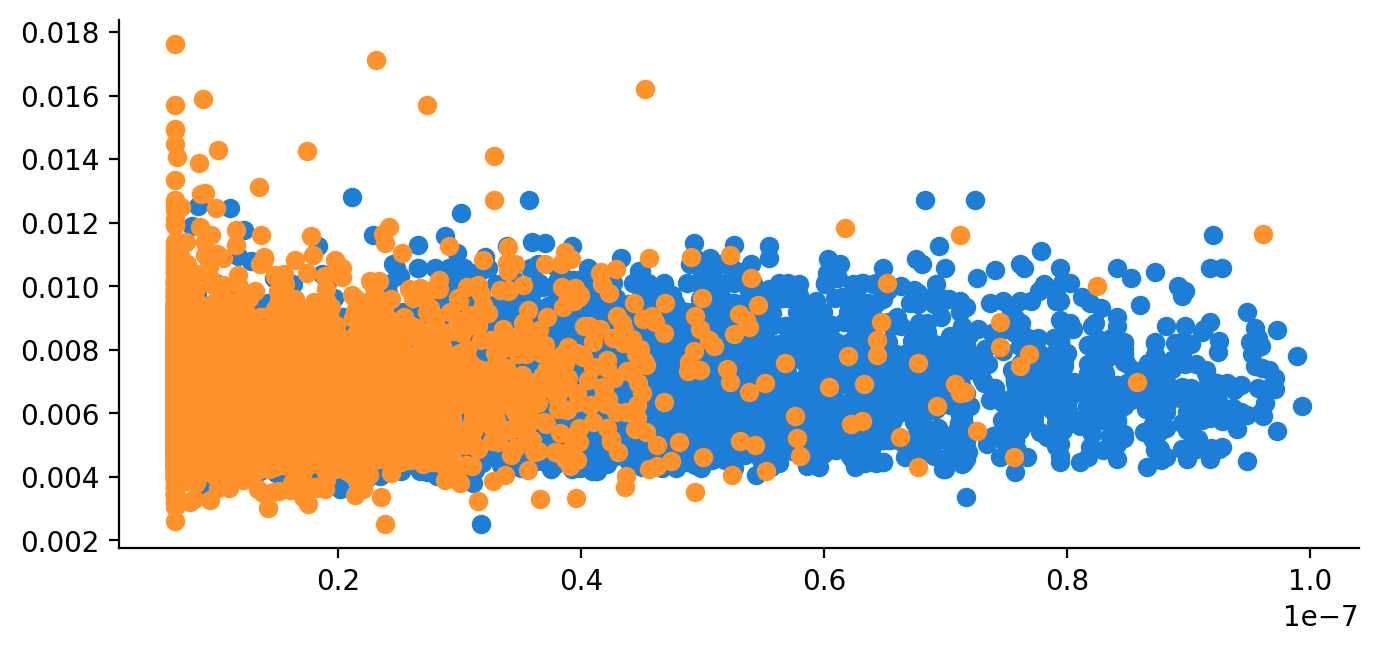

In [1059]:
plt.scatter(r, bl)
plt.scatter(r1, bl1)

(array([9.894e+03, 1.669e+03, 5.630e+02, 1.680e+02, 9.100e+01, 7.200e+01,
        1.100e+01, 5.000e+00, 3.000e+00, 5.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

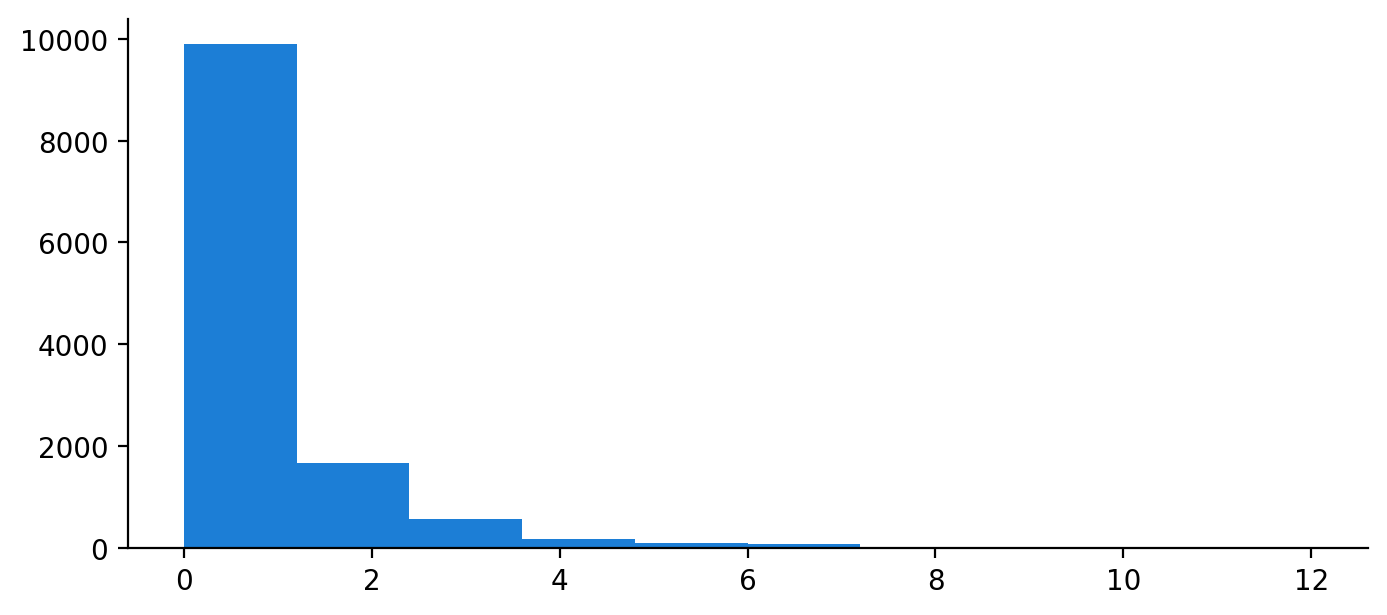

In [797]:
dnds = d['dnDs']
dnds = dnds[np.isfinite(dnds)]
plt.hist(dnds)

In [955]:
np.quantile(dnds, 0.99)

5.0

In [956]:
keep = (d['width'] > 10) & (d['dNdS'] < 5)
r, bl = r[keep], bl[keep]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6588 but corresponding boolean dimension is 16314

In [1060]:
def fit_JC69(predicted, subrate, gen_time=30):
    lambda_d, y = predicted/gen_time, subrate
    keep = np.isfinite(lambda_d) & np.isfinite(y)
    lambda_d, y = lambda_d[keep], y[keep]
    return lambda_d, y, curve_fit(JC69_parametric, lambda_d, y, p0=(0.02, 6e6, 0))

bin_xx, bin_yy, bin_fit = fit_JC69(binned_r, binned_bl)
xx, yy, fit = fit_JC69(r1, bl1)

In [1061]:
fit_JC69(r1, bl1)[2][0], fit_JC69(r, bl)[2][0]

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([7.59803031e-03, 4.31458274e+07, 1.49843883e-10]),
 array([9.27179968e-03, 3.84113959e+07, 1.58034296e-10]))

In [1064]:
fit_JC69(r1, bl1)[2][0][1]

43145827.42707077

In [803]:
dblx.sort_values('midpoint').tail()

,start,end,midpoint,mean,sd,n
12,7.817830e-08,7.269783e-08,7.543806e-08,0.006950,0.001496,104.0
13,8.365877e-08,7.817830e-08,8.091853e-08,0.007031,0.001306,119.0
14,8.913924e-08,8.365877e-08,8.639900e-08,0.006857,0.001302,87.0
15,9.461971e-08,8.913924e-08,9.187947e-08,0.006678,0.001506,76.0
17,1.055806e-07,1.001002e-07,1.028404e-07,0.006834,0.001200,183.0


Text(0.5, 0, 'predicted substitution rate')

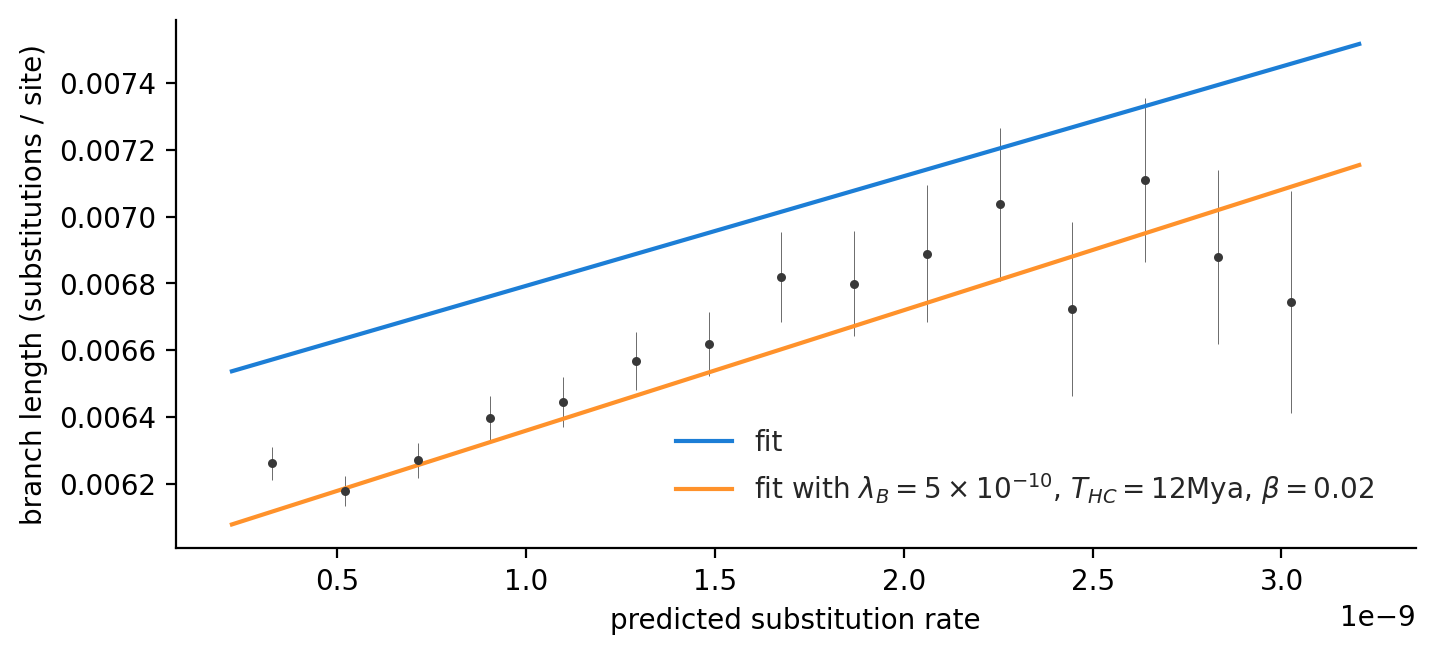

In [1070]:
fig, ax = plt.subplots()
ax.scatter(dblx['midpoint'].values/gen, dblx['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
ax.errorbar(dblx['midpoint']/gen, dblx['mean'], 2*dblx['sd']/np.sqrt(dblx['n']), fmt='none', c=error_col, elinewidth=0.3)

rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit[0]), label='fit')
#ax.plot(rate_grid, JC69_parametric(rate_grid, *bin_fit[0]), label='bin fit')

#ax.set_ylim(0.003, 0.012)


lit_lambda_b, lit_T, lit_beta = 5e-10, 12e6, 0.03
ax.plot(rate_grid, lit_lambda_b*lit_T + lit_T*lit_beta*rate_grid, 
        label='fit with $\\lambda_B = 5\\times 10^{-10}$, $T_{HC} = 12$Mya, $\\beta = 0.02$')
ax.legend()
ax.set_ylabel("branch length (substitutions / site)")
ax.set_xlabel("predicted substitution rate")

In [819]:
#a = binned_summaries(dpf2r['r'], dpf2r['branch_length'], nbins=50)
b = binned_summaries(dr2pf['r'], dr2pf['branch_length'], nbins=50)

<ErrorbarContainer object of 3 artists>

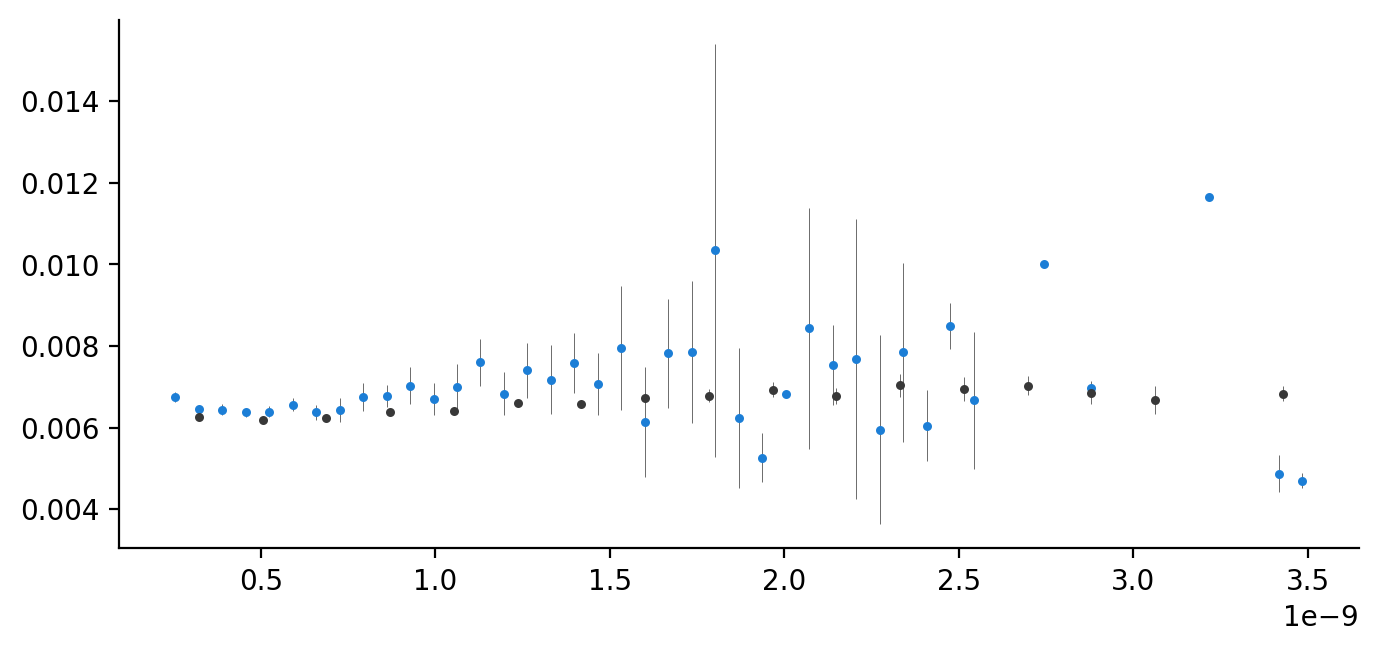

In [827]:
plt.scatter(b['midpoint']/gen, b['mean'], s=5, alpha=1, zorder=10)
plt.errorbar(b['midpoint']/gen, b['mean'], 2*b['sd']/np.sqrt(b['n']), fmt='none', c=error_col, elinewidth=0.3)

plt.scatter(dblx['midpoint'].values/gen, dblx['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
plt.errorbar(dblx['midpoint']/gen, dblx['mean'], 2*dblx['sd']/np.sqrt(dblx['n']), fmt='none', c=error_col, elinewidth=0.3)

In [791]:
def print_subfit(fit, gen_time=30):
    beta, T, a = fit[0]
    info = (f"intercept (λ_B T), a = {a:.3g}\n"
            f"  λ_B = {a / T:.3g} \n"
            f"T = {T/1e6:.4g} (Mya)\n"
            f"β = {beta:.3g}\n"
            f"{(a / T) / (a + T*beta*1e-9)}")
    print(info)
    
print_subfit(fit)

intercept (λ_B T), a = 3.22e-10
  λ_B = 1.67e-17 
T = 19.24 (Mya)
β = 0.0157
5.544491672682292e-14


In [792]:
print_subfit(bin_fit)

intercept (λ_B T), a = 3.18e-10
  λ_B = 1.63e-17 
T = 19.54 (Mya)
β = 0.0127
6.581669282481193e-14
